In [ ]:
## Notebook env: cellprofiler (R kernel)
### THIS NOTEBOOK NOT USED IN ANALYSIS. IGNORE. ###

In [1]:
suppressMessages(library(dplyr))
suppressMessages(library(tidyr))
suppressMessages(library(stringr))
suppressMessages(library(ggplot2))
suppressMessages(library(ggridges))
suppressMessages(library(ggpubr))

In [2]:
## Extract metadata
## No pertinent data in Image besides total object counts per image -- not helpful for heterogeneity
Image = read.csv('/home/ssobti/projects/heterogeneity_brian/output_data/cell_painting/10x_v1/Image.csv')
metadata = data.frame(ImageNumber = 1:nrow(Image), sample = Image$Metadata_Sample, site = Image$Metadata_Site, replicate = Image$Metadata_Replicate)
conditions = c('RNF8A-CRISPRi', 'MIS18A-CRISPRi', 'RUVBL1-CRISPRi', 'VRK1-CRISPRi', 'HMGA1-CRISPRi', 'RNF8A-CRISPRa', 'MIS18A-CRISPRa', 'NTCi', 'NTCa')
metadata$sample_name = plyr::mapvalues(metadata$sample, from = 1:9, to = conditions)
metadata = metadata %>% select('ImageNumber', 'sample', 'sample_name', 'site', 'replicate') %>% as.data.frame()
head(metadata)

,ImageNumber,sample,sample_name,site,replicate
,<int>,<int>,<chr>,<int>,<chr>
1,1,1,RNF8A-CRISPRi,1,A
2,2,1,RNF8A-CRISPRi,2,A
3,3,1,RNF8A-CRISPRi,3,A
4,4,1,RNF8A-CRISPRi,4,A
5,5,1,RNF8A-CRISPRi,5,A
6,6,1,RNF8A-CRISPRi,6,A


In [3]:
## load in data ##
cellbody = read.csv('/home/ssobti/projects/heterogeneity_brian/output_data/cell_painting/10x_v1/cellbody.csv')
cell_borders_secondary_via_nuclei = read.csv('/home/ssobti/projects/heterogeneity_brian/output_data/cell_painting/10x_v1/cell_borders_secondary_via_nuclei.csv')
cytoplasm_borders_tertiary_via_nuclei_primary_cell_borders_secondary = read.csv('/home/ssobti/projects/heterogeneity_brian/output_data/cell_painting/10x_v1/cytoplasm_borders_tertiary_via_nuclei_primary_cell_borders_secondary.csv')
ergolgi = read.csv('/home/ssobti/projects/heterogeneity_brian/output_data/cell_painting/10x_v1/ERGolgi.csv')
mitochondria = read.csv('/home/ssobti/projects/heterogeneity_brian/output_data/cell_painting/10x_v1/Mitochondria.csv')
nuclei = read.csv('/home/ssobti/projects/heterogeneity_brian/output_data/cell_painting/10x_v1/Nuclei.csv')

## for cell_borders_secondary_via_nuclei can use the cellbody channel for intensity measurements of cellbody (this dataframe is an alternative measurement of cellbody made via IdentifySecondaryObjects function in cellprofiler which uses the nuclei as a containing object to call the cellbody borders)
## for cytoplasm_borders_tertiary_via_nuclei_primary_cell_borders_secondary can only do size and shape measurements -- can't do intensity since cytoplasm never explicitly stained (this dataframe is a measurement of the cytoplasm made via IdentifyTertiaryObjects function in cellprofiler which subtracts the nuclei from the cell_borders_secondary_via_nuclei object)

## get rid of all objects of the wrong channel in each dataframe
## also getting rid of children count column(s) for nuclei df, and children_nuclei_count for cellbody df -- decide later if worth analyzing
cellbody = cellbody %>% select(-contains('ERGolgi'), -contains('Mitochondria'), -contains('DNA'), -contains('Location'), -contains('BoundingBox'), -contains('Center'), -contains('Children_Nuclei_Count'))
cell_borders_secondary_via_nuclei = cell_borders_secondary_via_nuclei %>% select(-contains('ERGolgi'), -contains('Mitochondria'), -contains('DNA'), -contains('Location'), -contains('BoundingBox'), -contains('Center'))
cytoplasm_borders_tertiary_via_nuclei_primary_cell_borders_secondary = cytoplasm_borders_tertiary_via_nuclei_primary_cell_borders_secondary %>% select(-contains('Intensity'), -contains('Location'))
ergolgi = ergolgi %>% select(-contains('cellbody'), -contains('Mitochondria'), -contains('DNA'), -contains('Location'), -contains('BoundingBox'), -contains('Center'))
mitochondria = mitochondria %>% select(-contains('cellbody'), -contains('ERGolgi'), -contains('DNA'), -contains('Location'), -contains('BoundingBox'), -contains('Center'))
nuclei = nuclei %>% select(-contains('cellbody'), -contains('ERGolgi'), -contains('Mitochondria'), -contains('Location'), -contains('BoundingBox'), -contains('Center'),  -contains('Children'))

cellbody = cellbody %>% rename_with(~str_remove(., '.cellbody'))
cell_borders_secondary_via_nuclei = cell_borders_secondary_via_nuclei %>% rename_with(~str_remove(., '.cellbody'))
cytoplasm_borders_tertiary_via_nuclei_primary_cell_borders_secondary = cytoplasm_borders_tertiary_via_nuclei_primary_cell_borders_secondary %>% rename_with(~str_remove(., '.cellbody'))
ergolgi = ergolgi %>% rename_with(~str_remove(., '.ERGolgi'))
mitochondria = mitochondria %>% rename_with(~str_remove(., '.Mitochondria'))
nuclei = nuclei %>% rename_with(~str_remove(., '.DNA'))

cellbody$channel = cellbody$object = 'cellbody'
cell_borders_secondary_via_nuclei$channel = 'cellbody'
cell_borders_secondary_via_nuclei$object = 'cell_borders_secondary_via_nuclei'
cytoplasm_borders_tertiary_via_nuclei_primary_cell_borders_secondary$channel = 'cellbody'
cytoplasm_borders_tertiary_via_nuclei_primary_cell_borders_secondary$object = 'cytoplasm_borders_tertiary_via_nuclei_primary_cell_borders_secondary'
ergolgi$channel = ergolgi$object = 'ergolgi'
mitochondria$channel = mitochondria$object = 'mitochondria'
nuclei$channel = nuclei$object = 'nuclei'


## merge metadata
data = list(cellbody, cell_borders_secondary_via_nuclei, cytoplasm_borders_tertiary_via_nuclei_primary_cell_borders_secondary, ergolgi, mitochondria, nuclei)
names(data) = c('cellbody', 'cell_borders_secondary_via_nuclei', 'cytoplasm_borders_tertiary_via_nuclei_primary_cell_borders_secondary', 'ergolgi', 'mitochondria', 'nuclei')
data = lapply(data, left_join, metadata, by = 'ImageNumber')

## remove images with aberrant object calls
imgs_to_remove = data[['nuclei']] %>% filter((sample_name == 'NTCa' & replicate == 'A' & site == 7) | (sample_name == 'NTCi' & replicate == 'B' & site == 9)) %>% pull(ImageNumber) %>% unique()
nuclei = nuclei %>% filter(!(ImageNumber %in% imgs_to_remove))
cellbody = cellbody %>% filter(!(ImageNumber %in% imgs_to_remove))
cell_borders_secondary_via_nuclei = cell_borders_secondary_via_nuclei %>% filter(!(ImageNumber %in% imgs_to_remove))
cytoplasm_borders_tertiary_via_nuclei_primary_cell_borders_secondary = cytoplasm_borders_tertiary_via_nuclei_primary_cell_borders_secondary %>% filter(!(ImageNumber %in% imgs_to_remove))
ergolgi = ergolgi %>% filter(!(ImageNumber %in% imgs_to_remove))
mitochondria = mitochondria %>% filter(!(ImageNumber %in% imgs_to_remove))

data[['cellbody']] = data[['cellbody']] %>% filter(!(ImageNumber %in% imgs_to_remove))
data[['cell_borders_secondary_via_nuclei']] = data[['cell_borders_secondary_via_nuclei']] %>% filter(!(ImageNumber %in% imgs_to_remove))
data[['cytoplasm_borders_tertiary_via_nuclei_primary_cell_borders_secondary']] = data[['cytoplasm_borders_tertiary_via_nuclei_primary_cell_borders_secondary']] %>% filter(!(ImageNumber %in% imgs_to_remove))
data[['ergolgi']] = data[['ergolgi']] %>% filter(!(ImageNumber %in% imgs_to_remove))
data[['mitochondria']] = data[['mitochondria']] %>% filter(!(ImageNumber %in% imgs_to_remove))
data[['nuclei']] = data[['nuclei']] %>% filter(!(ImageNumber %in% imgs_to_remove))


In [4]:
## simple to show histograms of between conditions
## per object metrics
# 'AreaShape_Area', 'Intensity_MeanIntensity_....', 'Intensity_MedianIntensity_....',  
# 'Intensity_IntegratedIntensity_...', Intensity_MaxIntensity_....'

## combine cellbody, mitochondria, ergolgi, nuclei into one dataframe
## combine replicates in data to capture well to well variability (ie don't stratify on replicate column)

primary_objects_data = bind_rows(data[['cellbody']], data[['mitochondria']], data[['ergolgi']], data[['nuclei']])
primary_objects_data$sample_name = factor(primary_objects_data$sample_name, levels = rev(conditions))


## show ridgeline plots between conditions with CV
# Area
channels = unique(primary_objects_data$channel)
Area_ridge_plts = list()
scale_mins = c(0, 0, 0, 0)
scale_maxs = c(4500, 1500, 2500, 1000)
for (i in 1:length(channels)){
  CV_vals = primary_objects_data %>% filter(channel == channels[i]) %>% select(AreaShape_Area, sample_name) %>% group_by(sample_name) %>% summarize(CV = signif(sd(AreaShape_Area)/mean(AreaShape_Area), 2), AreaShape_Area = mean(AreaShape_Area))
  Area_ridge_plts[[i]] = primary_objects_data %>% filter(channel == channels[i]) %>% select(AreaShape_Area, sample_name) %>% ggplot(aes(x = AreaShape_Area, y = sample_name)) +
  geom_density_ridges(aes(fill = sample_name), show.legend = FALSE) +
  scale_fill_viridis_d() + ggtitle(paste(str_to_title(channels[i]), 'Area by Condition', sep = ' ')) + geom_text(aes(label = CV, group = sample_name), data = CV_vals, hjust = -2, vjust = -1, size = 5) +
  theme_pubr() + xlab('Area') + ylab('') + theme(plot.title = element_text(hjust = 0.5)) + xlim(scale_mins[i], scale_maxs[i])

}

# Intensity
channels = unique(primary_objects_data$channel)
Intensity_ridge_plts = list()
scale_mins = c(0, 0, 0, 0)
scale_maxs = c(2000, 300, 600, 100)
for (i in 1:length(channels)){
  CV_vals = primary_objects_data %>% filter(channel == channels[i]) %>% select(Intensity_IntegratedIntensity, sample_name) %>% group_by(sample_name) %>% summarize(CV = signif(sd(Intensity_IntegratedIntensity)/mean(Intensity_IntegratedIntensity), 2), Intensity_IntegratedIntensity = mean(Intensity_IntegratedIntensity))
  Intensity_ridge_plts[[i]] = primary_objects_data %>% filter(channel == channels[i]) %>% select(Intensity_IntegratedIntensity, sample_name) %>% ggplot(aes(x = Intensity_IntegratedIntensity, y = sample_name)) +
  geom_density_ridges(aes(fill = sample_name), show.legend = FALSE) +
  scale_fill_viridis_d() + ggtitle(paste(str_to_title(channels[i]), 'Integrated Intensity by Condition', sep = ' ')) + geom_text(aes(label = CV, group = sample_name), data = CV_vals, hjust = -2, vjust = -1, size = 5) +
  theme_pubr() + xlab('Integrated Intensity') + ylab('') + theme(plot.title = element_text(hjust = 0.5)) + xlim(scale_mins[i], scale_maxs[i])

}


## can also use violin plots as alternate to histograms between conditions
# Area
channels = unique(primary_objects_data$channel)
Area_violin_plts = list()
scale_mins = c(0, 0, 0, 0)
scale_maxs = c(4500, 1500, 2500, 1000)
for (i in 1:length(channels)){
  CV_vals = primary_objects_data %>% filter(channel == channels[i]) %>% select(AreaShape_Area, sample_name) %>% group_by(sample_name) %>% summarize(CV = signif(sd(AreaShape_Area)/mean(AreaShape_Area), 2), AreaShape_Area = mean(AreaShape_Area))
  Area_violin_plts[[i]] = primary_objects_data %>% filter(channel == channels[i]) %>% select(AreaShape_Area, sample_name) %>% ggplot(aes(x = sample_name, y = AreaShape_Area)) +
  geom_violin(aes(fill = sample_name), show.legend = FALSE, trim = FALSE) +
  scale_fill_viridis_d() + ggtitle(paste(str_to_title(channels[i]), 'Area by Condition', sep = ' ')) + geom_text(aes(label = CV, group = sample_name), data = CV_vals, hjust = -0.1, vjust = -10, size = 5) +
  theme_pubr() + xlab('') + ylab('Area') + theme(plot.title = element_text(hjust = 0.5), axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)) + ylim(scale_mins[i], scale_maxs[i])

}

# Intensity
channels = unique(primary_objects_data$channel)
Intensity_violin_plts = list()
scale_mins = c(0, 0, 0, 0)
scale_maxs = c(2000, 300, 600, 100)
for (i in 1:length(channels)){
  CV_vals = primary_objects_data %>% filter(channel == channels[i]) %>% select(Intensity_IntegratedIntensity, sample_name) %>% group_by(sample_name) %>% summarize(CV = signif(sd(Intensity_IntegratedIntensity)/mean(Intensity_IntegratedIntensity), 2), Intensity_IntegratedIntensity = mean(Intensity_IntegratedIntensity))
  Intensity_violin_plts[[i]] = primary_objects_data %>% filter(channel == channels[i]) %>% select(Intensity_IntegratedIntensity, sample_name) %>% ggplot(aes(x = sample_name, y = Intensity_IntegratedIntensity)) +
  geom_violin(aes(fill = sample_name), show.legend = FALSE, trim = FALSE) +
  scale_fill_viridis_d() + ggtitle(paste(str_to_title(channels[i]), 'Integrated Intensity by Condition', sep = ' ')) + geom_text(aes(label = CV, group = sample_name), data = CV_vals, hjust = -0.1, vjust = -10, size = 5) +
  theme_pubr() + xlab('') + ylab('Integrated Intensity') + theme(plot.title = element_text(hjust = 0.5), axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)) + ylim(scale_mins[i], scale_maxs[i])

}

## make heatmap of CV values of these features across conditions
# area and intensity
select_features_primary_objects_data_CV = primary_objects_data %>% select('AreaShape_Area', 'Intensity_IntegratedIntensity', 'Intensity_MeanIntensity', 'Intensity_MedianIntensity', 'Intensity_MaxIntensity', 'sample_name', 'channel') %>% group_by(sample_name, channel) %>% summarize(AreaShape_Area_CV = signif(sd(AreaShape_Area)/mean(AreaShape_Area), 3), Intensity_IntegratedIntensity_CV = signif(sd(Intensity_IntegratedIntensity)/mean(Intensity_IntegratedIntensity), 3), Intensity_MeanIntensity_CV = signif(sd(Intensity_MeanIntensity)/mean(Intensity_MeanIntensity), 3), Intensity_MedianIntensity_CV = signif(sd(Intensity_MedianIntensity)/mean(Intensity_MedianIntensity), 3), Intensity_MaxIntensity_CV = signif(sd(Intensity_MaxIntensity)/mean(Intensity_MaxIntensity), 3)) %>% as.data.frame()
rownames(select_features_primary_objects_data_CV) = paste(select_features_primary_objects_data_CV$sample_name, select_features_primary_objects_data_CV$channel, sep = '_')
select_features_primary_objects_data_CV_mtx = select_features_primary_objects_data_CV %>% select(-sample_name, -channel) %>% as.matrix()
#head(select_features_primary_objects_data_CV_mtx)

# shape
CV_func = function(x){sd(x, na.rm = TRUE)/mean(x, na.rm = TRUE)}
## convert all infinities to NA
primary_objects_data = primary_objects_data %>% mutate_all(~replace(., is.infinite(.), NA)) %>% drop_na() ## remove any object with infinite value for any feature
shape_features_primary_objects_data_CV = primary_objects_data %>% select('AreaShape_Compactness', 'AreaShape_ConvexArea', 'AreaShape_Eccentricity', 'AreaShape_EquivalentDiameter', 'AreaShape_EulerNumber', 'AreaShape_Extent', 'AreaShape_FormFactor', 'AreaShape_MajorAxisLength', 'AreaShape_MinorAxisLength',
'AreaShape_MaxFeretDiameter', 'AreaShape_MaximumRadius', 'AreaShape_MeanRadius', 'AreaShape_MedianRadius', 'AreaShape_MinFeretDiameter', 'AreaShape_Orientation', 
'AreaShape_Perimeter', 'AreaShape_Solidity', 
'AreaShape_Zernike_0_0', 'AreaShape_Zernike_1_1', 'AreaShape_Zernike_2_0', 'AreaShape_Zernike_2_2', 'AreaShape_Zernike_3_1', 'AreaShape_Zernike_3_3', 'AreaShape_Zernike_4_0', 'AreaShape_Zernike_4_2', 'AreaShape_Zernike_4_4', 'AreaShape_Zernike_5_1', 'AreaShape_Zernike_5_3', 'AreaShape_Zernike_5_5', 'AreaShape_Zernike_6_0', 'AreaShape_Zernike_6_2', 'AreaShape_Zernike_6_4', 'AreaShape_Zernike_6_6', 'AreaShape_Zernike_7_1', 'AreaShape_Zernike_7_3', 'AreaShape_Zernike_7_5', 'AreaShape_Zernike_7_7', 'AreaShape_Zernike_8_0', 'AreaShape_Zernike_8_2', 'AreaShape_Zernike_8_4', 'AreaShape_Zernike_8_6', 'AreaShape_Zernike_8_8', 'AreaShape_Zernike_9_1', 'AreaShape_Zernike_9_3', 'AreaShape_Zernike_9_5', 'AreaShape_Zernike_9_7', 'AreaShape_Zernike_9_9',
'Intensity_MassDisplacement', 'sample_name', 'channel') %>% group_by(sample_name, channel) %>% summarize_all(CV_func) %>% as.data.frame()
rownames(shape_features_primary_objects_data_CV) = paste(shape_features_primary_objects_data_CV$sample_name, shape_features_primary_objects_data_CV$channel, sep = '_')
shape_features_primary_objects_data_CV_mtx = shape_features_primary_objects_data_CV %>% select(-sample_name, -channel) %>% as.matrix()
#head(shape_features_primary_objects_data_CV_mtx)


`summarise()` has grouped output by 'sample_name'. You can override using the
`.groups` argument.


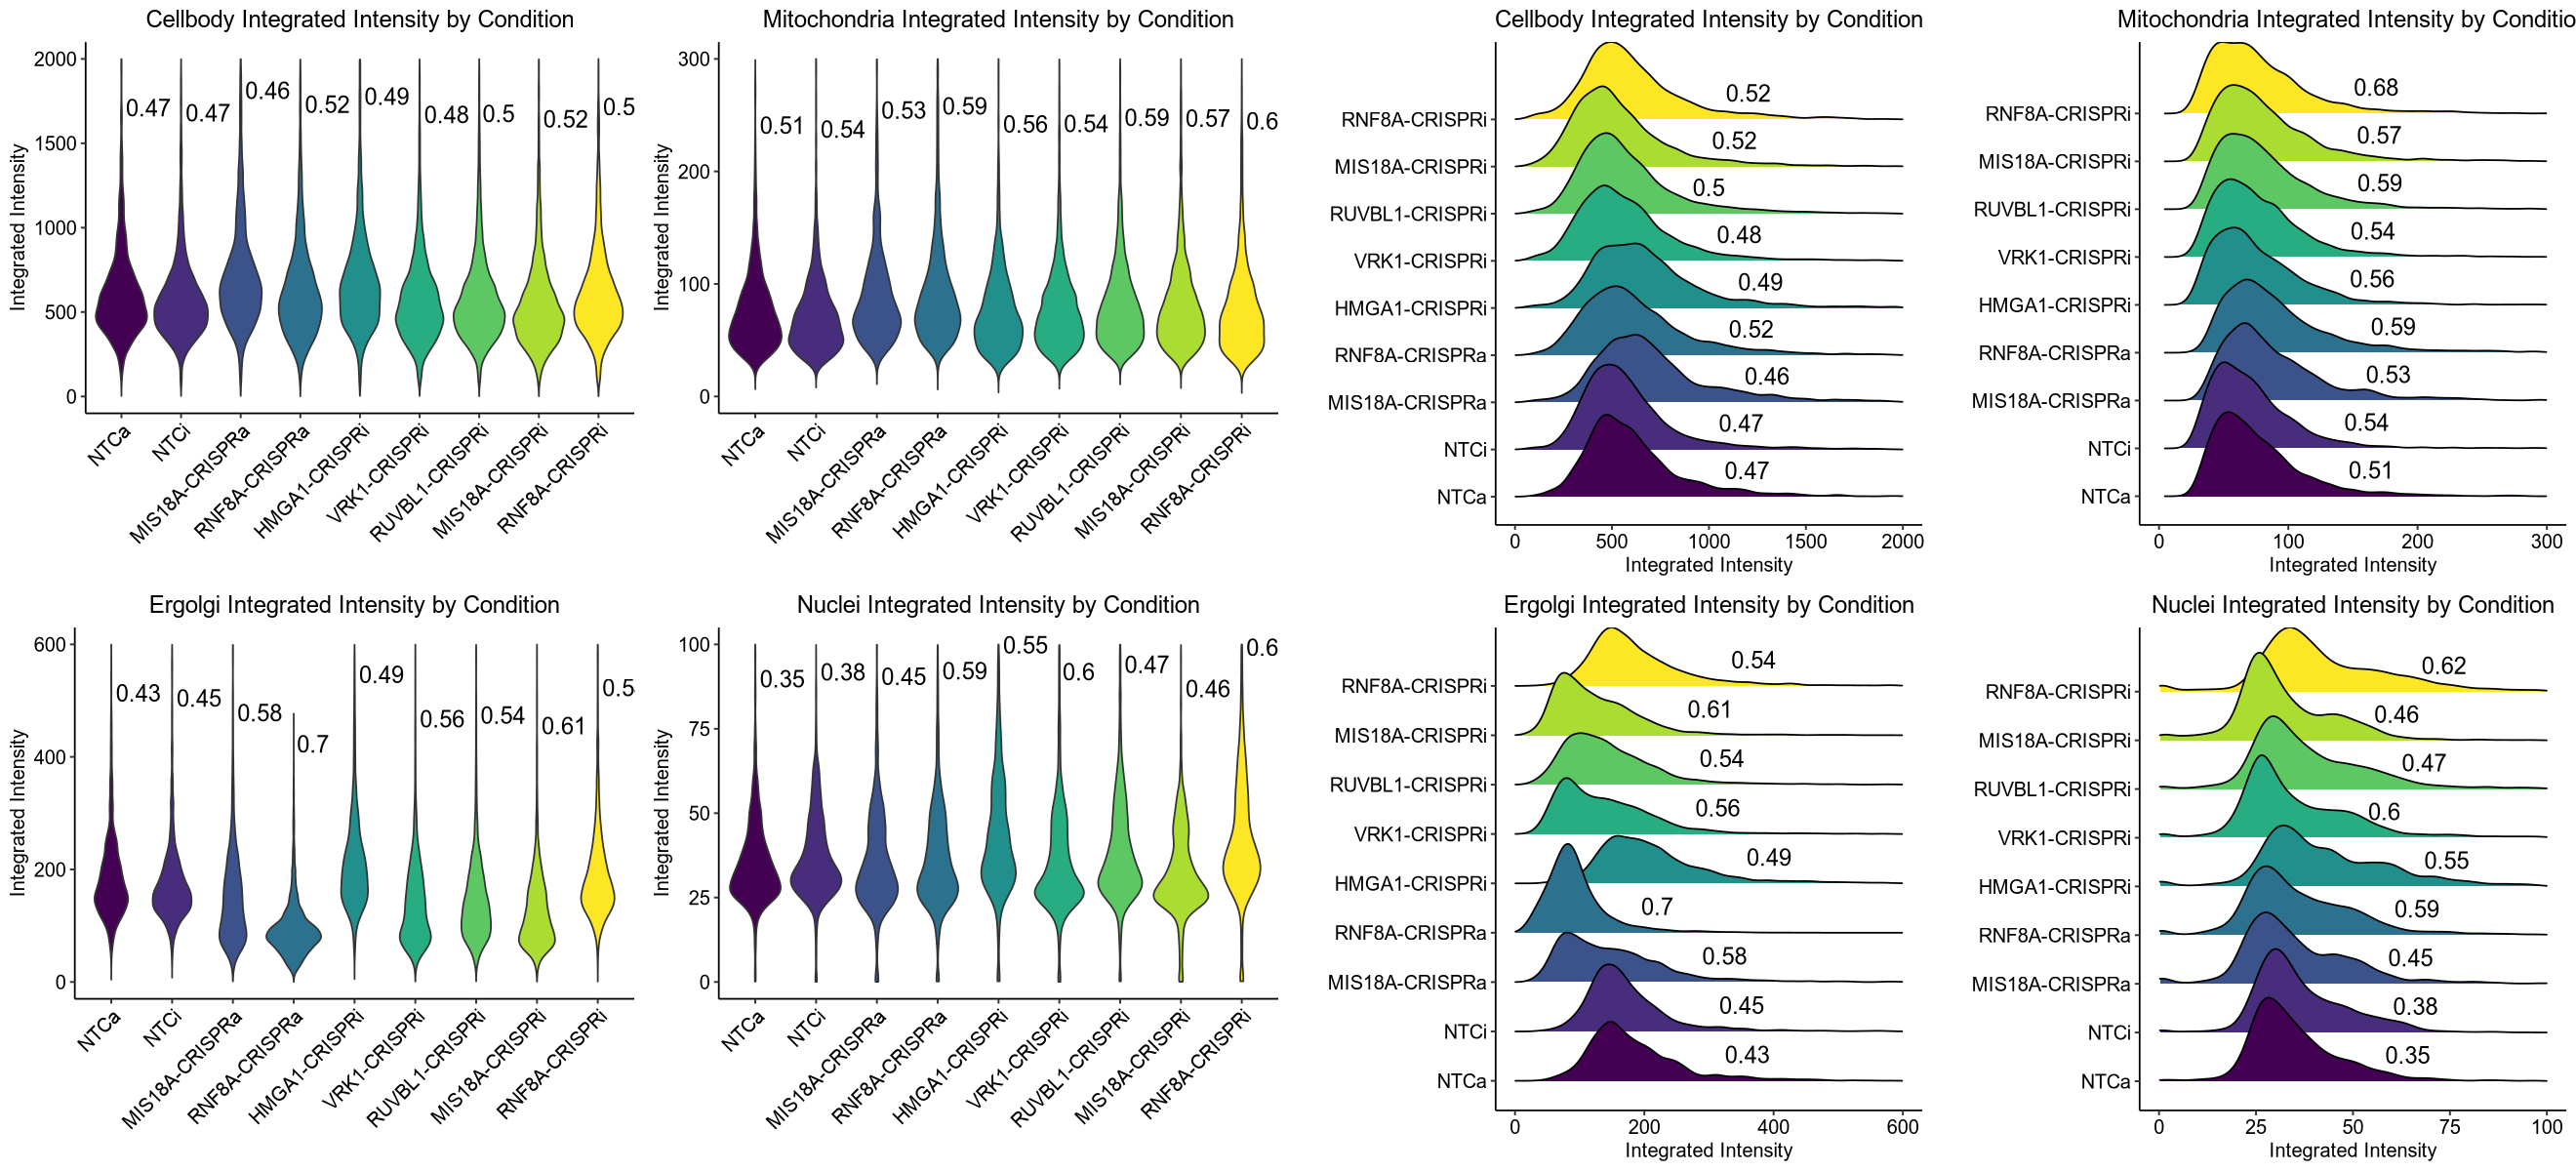

In [5]:
## violin and ridge plots of object integrated intensity across conditions ##
options(repr.plot.width = 22, repr.plot.height = 10)
ggarrange(suppressMessages(suppressWarnings(ggarrange(plotlist = Intensity_violin_plts, ncol = 2, nrow = 2))), suppressMessages(suppressWarnings(ggarrange(plotlist = Intensity_ridge_plts, ncol = 2, nrow = 2))))

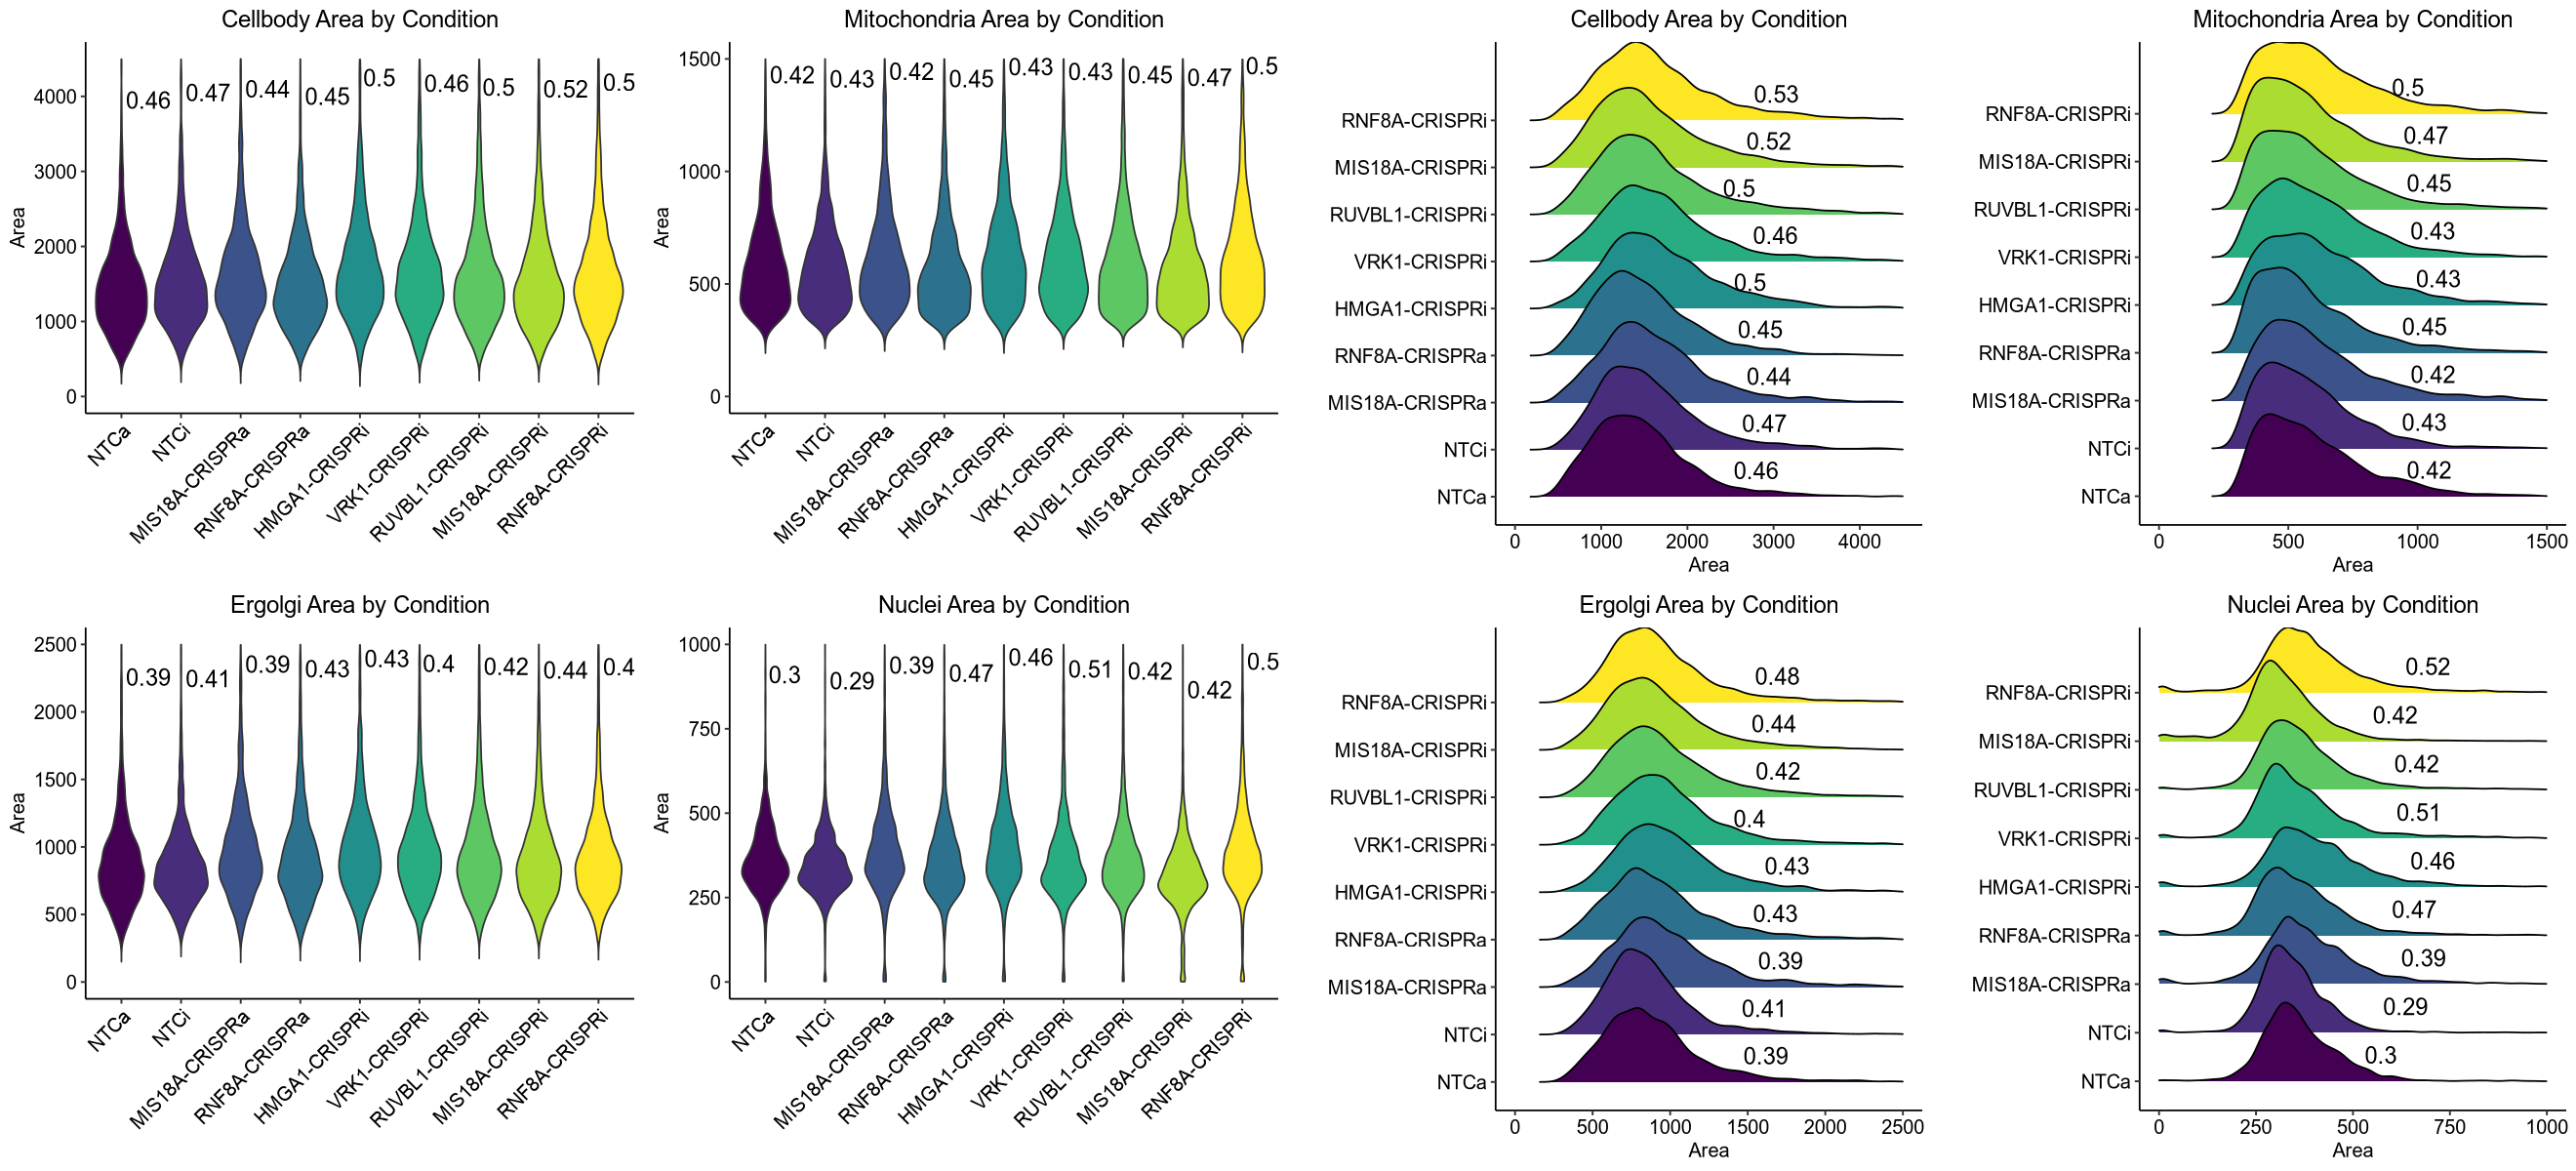

In [6]:
## violin and ridge plots of object area across conditions ##
options(repr.plot.width = 22, repr.plot.height = 10)
ggarrange(suppressMessages(suppressWarnings(ggarrange(plotlist = Area_violin_plts, ncol = 2, nrow = 2))), suppressMessages(suppressWarnings(ggarrange(plotlist = Area_ridge_plts, ncol = 2, nrow = 2))))

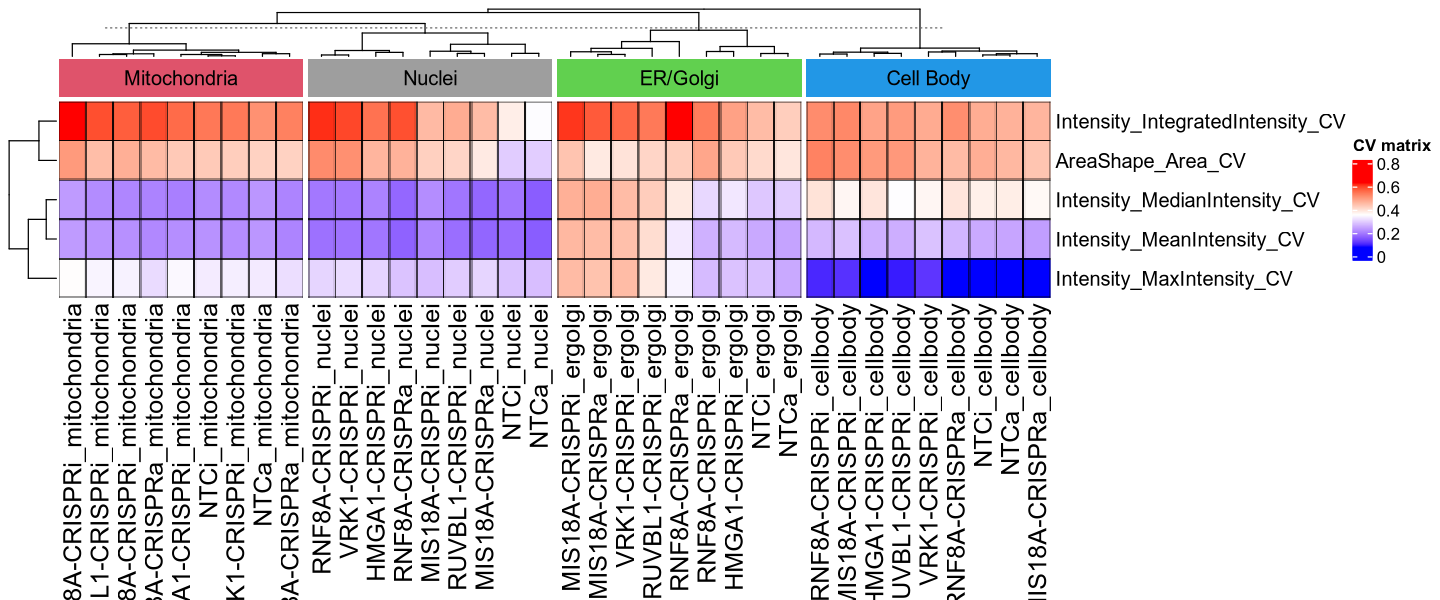

In [47]:
## heatmap of CV values of object intensity and area features across conditions ##
options(repr.plot.width=12, repr.plot.height=5)
suppressMessages(suppressWarnings(library(ComplexHeatmap)))
suppressMessages(suppressWarnings(library(gridExtra)))
ht_opt$message = FALSE

avg = mean(select_features_primary_objects_data_CV_mtx)
lower_bound = mean(select_features_primary_objects_data_CV_mtx) - 2*sd(select_features_primary_objects_data_CV_mtx)
upper_bound = mean(select_features_primary_objects_data_CV_mtx) + 2*sd(select_features_primary_objects_data_CV_mtx)
coloring_map <- circlize::colorRamp2(c(lower_bound, avg, upper_bound), c("blue", "white", "red"))

n = select_features_primary_objects_data_CV_mtx %>% nrow() / 4
labels = c(rep('Cell Body', n), rep('ER/Golgi', n), rep('Mitochondria', n), rep('Nuclei', n))
labels = factor(labels, levels = unique(labels))
select_reordered_features_primary_objects_data_CV_mtx = t(select_features_primary_objects_data_CV_mtx)[, order(match(sapply(str_split(colnames(t(select_features_primary_objects_data_CV_mtx)) , '_'), '[[', 2), c('cellbody', 'ergolgi', 'mitochondria', 'nuclei')))]

htmp <- function(matrix, title) {
  Heatmap(matrix, name = title, show_column_names = TRUE, show_row_names = TRUE, show_column_dend = TRUE,
               col = coloring_map, show_row_dend = TRUE, use_raster = TRUE, row_title = NULL, column_split = labels,
               column_title = NULL, row_title_side = 'left', column_title_side = 'top', cluster_row_slices = TRUE, cluster_column_slices = TRUE,
               column_names_gp = gpar(fontsize = 15), row_names_gp = gpar(fontsize = 12), rect_gp = gpar(col = "black", lwd = 1), column_gap = unit(1, 'mm'),
               top_annotation = HeatmapAnnotation(foo = anno_block(gp = gpar(fill = c(2,8,3,4), col = 0), labels = c('Mitochondria', 'Nuclei', 'ER/Golgi', 'Cell Body'))))
}


ht = select_reordered_features_primary_objects_data_CV_mtx %>% htmp('CV matrix')
ht

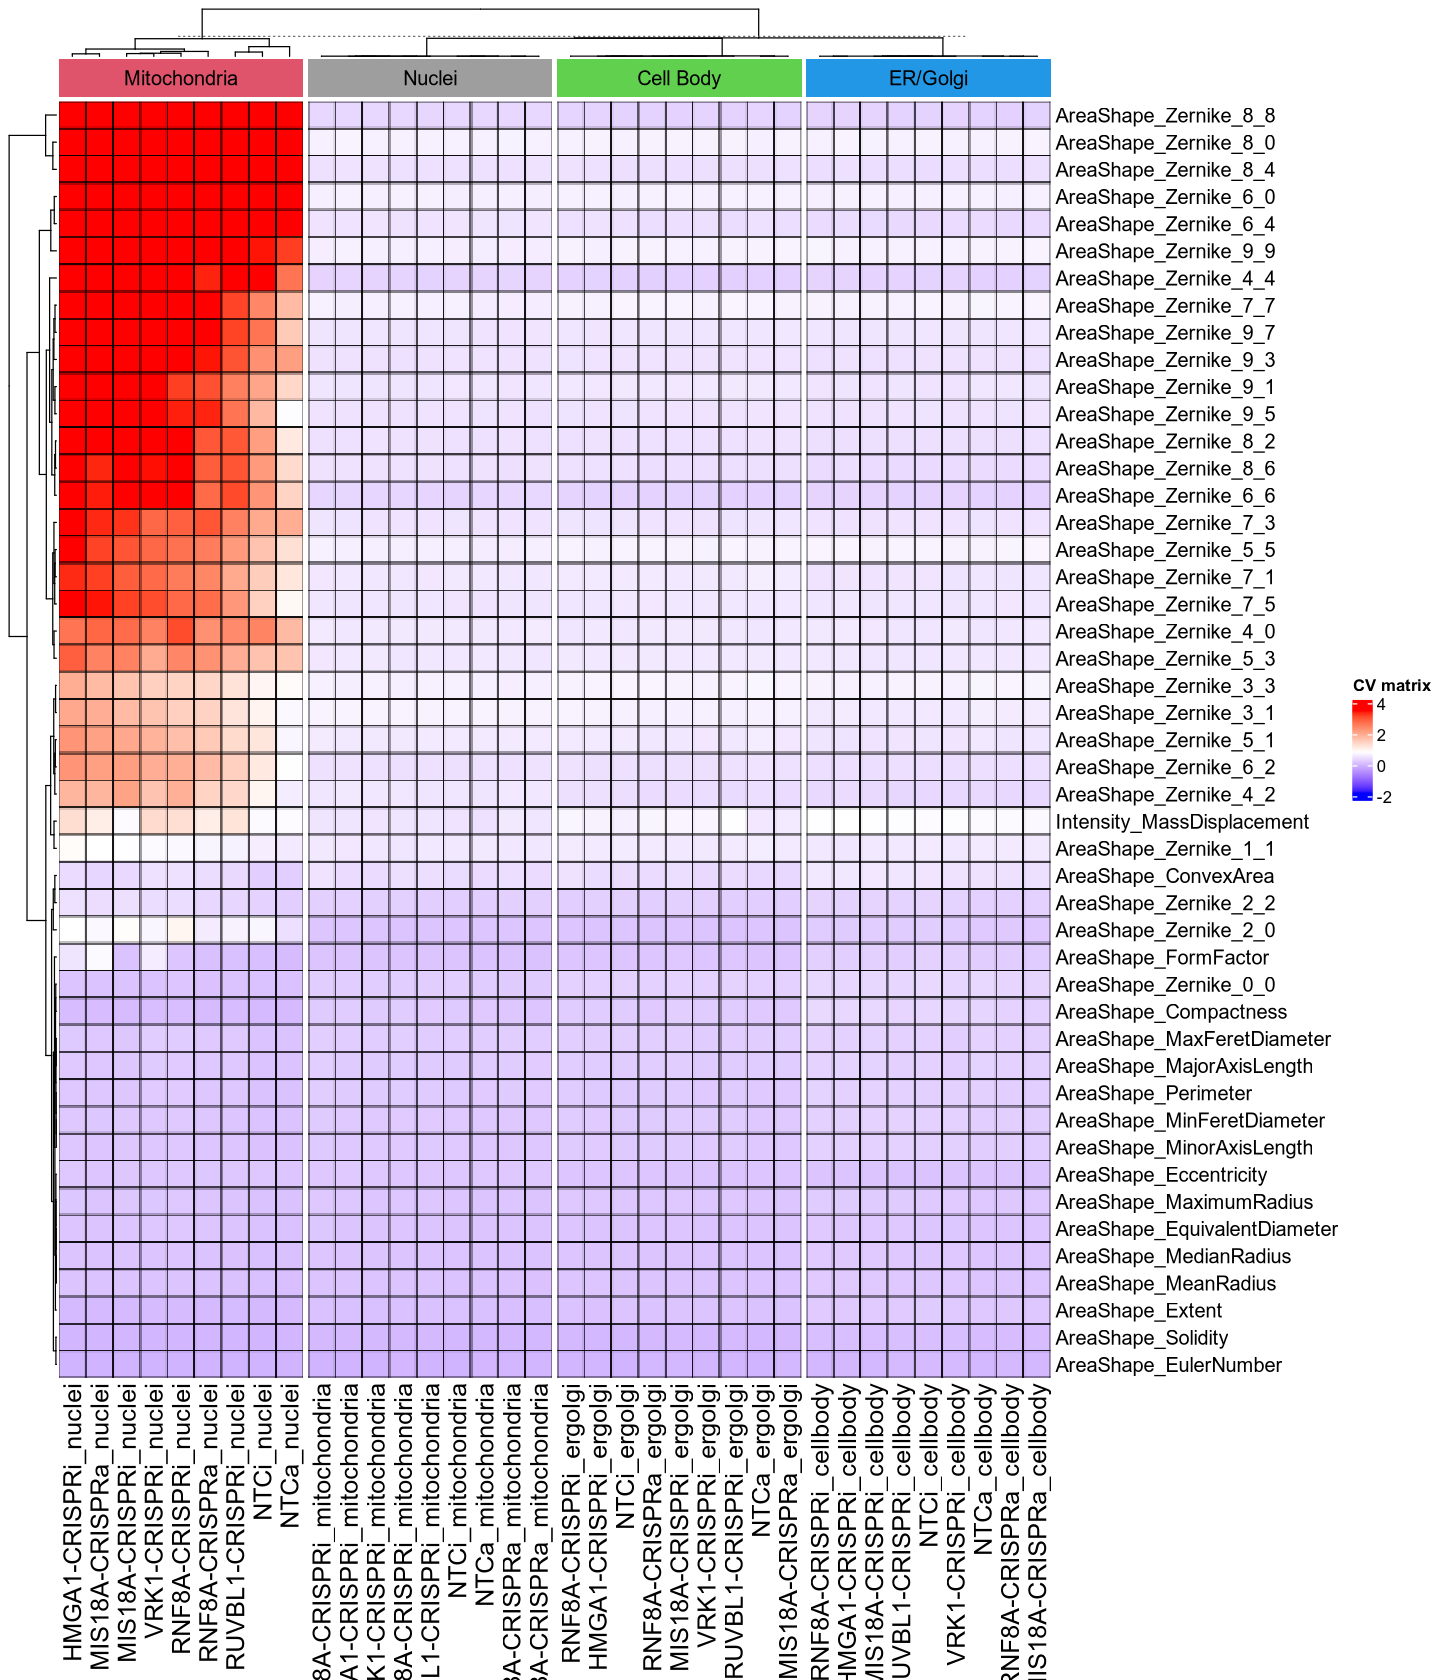

In [20]:
## heatmap of CV values of shape features across conditions ##
options(repr.plot.width=12, repr.plot.height=14)
suppressMessages(suppressWarnings(library(ComplexHeatmap)))
suppressMessages(suppressWarnings(library(gridExtra)))
ht_opt$message = FALSE

## remove 'AreaShape_Orientation' as not informative for heterogeneity between conditions
shape_features_primary_objects_data_CV_mtx2 = shape_features_primary_objects_data_CV_mtx %>% as.data.frame() %>% select(-'AreaShape_Orientation') %>% as.matrix()
avg = mean(shape_features_primary_objects_data_CV_mtx2)
lower_bound = mean(shape_features_primary_objects_data_CV_mtx2) - 2*sd(shape_features_primary_objects_data_CV_mtx2)
upper_bound = mean(shape_features_primary_objects_data_CV_mtx2) + 2*sd(shape_features_primary_objects_data_CV_mtx2)
coloring_map <- circlize::colorRamp2(c(lower_bound, avg, upper_bound), c("blue", "white", "red"))

n = shape_features_primary_objects_data_CV_mtx2 %>% nrow() / 4
labels = c(rep('Cell Body', n), rep('ER/Golgi', n), rep('Mitochondria', n), rep('Nuclei', n))
labels = factor(labels, levels = unique(labels))
select_reordered_features_primary_objects_data_CV_mtx = t(shape_features_primary_objects_data_CV_mtx2)[, order(match(sapply(str_split(colnames(t(shape_features_primary_objects_data_CV_mtx2)) , '_'), '[[', 2), c('cellbody', 'ergolgi', 'mitochondria', 'nuclei')))]

htmp <- function(matrix, title) {
  Heatmap(matrix, name = title, show_column_names = TRUE, show_row_names = TRUE, show_column_dend = TRUE,
               col = coloring_map, show_row_dend = TRUE, use_raster = TRUE, row_title = NULL, column_split = labels,
               column_title = NULL, row_title_side = 'left', column_title_side = 'top', cluster_row_slices = TRUE, cluster_column_slices = TRUE,
               column_names_gp = gpar(fontsize = 15), row_names_gp = gpar(fontsize = 12), rect_gp = gpar(col = "black", lwd = 1), column_gap = unit(1, 'mm'),
               top_annotation = HeatmapAnnotation(foo = anno_block(gp = gpar(fill = c(2,8,3,4), col = 0), labels = c('Mitochondria', 'Nuclei', 'Cell Body', 'ER/Golgi'))))
}


ht = select_reordered_features_primary_objects_data_CV_mtx %>% htmp('CV matrix')
ht

### Identifying features where CRISPRi creates decrease in CV and CRISPRa creates increase in CV ###

In [ ]:
## Identify features where CRISPRi creates decrease in CV and CRISPRa creates increase in CV
condition_catch = list()

for (j in 1:4){
    table = select_reordered_features_primary_objects_data_CV_mtx[, (9*(j-1) + 1):(9*j)]
    
    n = 1
    for (i in 1:nrow(select_reordered_features_primary_objects_data_CV_mtx)){
        if (min(table[i, grepl(colnames(table), pattern = 'CRISPRa')]) > max(table[i, grepl(colnames(table), pattern = 'CRISPRi')]) 
        & min(table[i, grepl(colnames(table), pattern = 'CRISPRa')]) > table[i, grepl(colnames(table), pattern = 'Ca')] & 
        min(table[i, grepl(colnames(table), pattern = 'CRISPRi')]) < table[i, grepl(colnames(table), pattern = 'Ci')]){
            if (n > 1){
                condition_catch[[j]] = c(condition_catch[[j]], rownames(table)[i])

            } else{
                condition_catch[[j]] = rownames(table)[i]
            }
        n = n + 1
        }
        

    }

}

## if contains 'Ca' or 'CRISPRa' then increase in CV
## if contains 'Ci' or 'CRISPRi' then decrease in CV


In [ ]:
## additional condition of CRISPRa > Ca and CRISPRi < Ci in CV
condition_catch

[[1]]
[1] "AreaShape_Zernike_5_5" "AreaShape_Zernike_9_5"

[[2]]
[1] "AreaShape_Zernike_7_5"

In [ ]:
j = 1
table = select_reordered_features_primary_objects_data_CV_mtx[, (9*(j-1) + 1):(9*j)]
table[match(condition_catch[[j]], rownames(table)), ]

,NTCa_cellbody,NTCi_cellbody,MIS18A-CRISPRa_cellbody,RNF8A-CRISPRa_cellbody,HMGA1-CRISPRi_cellbody,VRK1-CRISPRi_cellbody,RUVBL1-CRISPRi_cellbody,MIS18A-CRISPRi_cellbody,RNF8A-CRISPRi_cellbody
AreaShape_Zernike_1_1,0.6168938,0.6151950,0.6082023,0.6151501,0.5761898,0.5785467,0.5904614,0.5932509,0.5981868
AreaShape_Zernike_3_1,0.6580563,0.5937172,0.6327361,0.6266013,0.6261682,0.5920772,0.5887758,0.5949673,0.6056313
AreaShape_Zernike_3_3,0.7372786,0.7053556,0.7422942,0.7273719,0.6984066,0.6990712,0.7084446,0.6993007,0.7043171
AreaShape_Zernike_5_1,0.5899167,0.5556749,0.5680608,0.5644605,0.5448122,0.5494734,0.5511358,0.5411671,0.5634016
AreaShape_Zernike_5_5,0.7060377,0.7182870,0.7459096,0.7421092,0.7250283,0.7052683,0.7166801,0.7051700,0.7293759
AreaShape_Zernike_7_1,0.5713083,0.5495572,0.5714075,0.5635981,0.5504140,0.5447358,0.5523150,0.5394567,0.5389630
AreaShape_Zernike_7_3,0.5470339,0.5327177,0.5417801,0.5400682,0.5258744,0.5355613,0.5334781,0.5303027,0.5372936
AreaShape_Zernike_7_7,0.7415766,0.7157813,0.7283370,0.7244655,0.6962363,0.7093171,0.6987765,0.7089347,0.7056065
AreaShape_Zernike_9_1,0.5789690,0.5412953,0.5568491,0.5848665,0.5556629,0.5385975,0.5551352,0.5413824,0.5506793
AreaShape_Zernike_9_5,0.5367064,0.5438740,0.5480814,0.5456198,0.5297065,0.5286395,0.5408742,0.5219245,0.5335962


In [ ]:
j = 2
table = select_reordered_features_primary_objects_data_CV_mtx[, (9*(j-1) + 1):(9*j)]
table[match(condition_catch[[j]], rownames(table)), ]

,NTCa_ergolgi,NTCi_ergolgi,MIS18A-CRISPRa_ergolgi,RNF8A-CRISPRa_ergolgi,HMGA1-CRISPRi_ergolgi,VRK1-CRISPRi_ergolgi,RUVBL1-CRISPRi_ergolgi,MIS18A-CRISPRi_ergolgi,RNF8A-CRISPRi_ergolgi
AreaShape_Zernike_6_0,0.6853936,0.6732612,0.6984958,0.6917047,0.6896177,0.6753959,0.6878198,0.6849956,0.6801581
AreaShape_Zernike_7_1,0.6616648,0.6166463,0.6228811,0.6226075,0.6155170,0.6015928,0.6097383,0.5948186,0.6138879
AreaShape_Zernike_7_5,0.5834239,0.5891809,0.5935697,0.5873794,0.5717800,0.5778988,0.5854227,0.5807345,0.5733514


In [ ]:
j = 3
table = select_reordered_features_primary_objects_data_CV_mtx[, (9*(j-1) + 1):(9*j)]
table[match(condition_catch[[j]], rownames(table)), ]

,NTCa_mitochondria,NTCi_mitochondria,MIS18A-CRISPRa_mitochondria,RNF8A-CRISPRa_mitochondria,HMGA1-CRISPRi_mitochondria,VRK1-CRISPRi_mitochondria,RUVBL1-CRISPRi_mitochondria,MIS18A-CRISPRi_mitochondria,RNF8A-CRISPRi_mitochondria
AreaShape_Zernike_6_6,0.3846781,0.3712052,0.4002439,0.3969553,0.3959601,0.3879271,0.3800409,0.3839316,0.3874823
Intensity_MassDisplacement,0.5193697,0.5321378,0.5691377,0.6048032,0.5571098,0.5511061,0.5634413,0.5634888,0.5607738


In [ ]:
condition_catch

[[1]]
 [1] "AreaShape_Zernike_1_1" "AreaShape_Zernike_3_1" "AreaShape_Zernike_3_3"
 [4] "AreaShape_Zernike_5_1" "AreaShape_Zernike_5_5" "AreaShape_Zernike_7_1"
 [7] "AreaShape_Zernike_7_3" "AreaShape_Zernike_7_7" "AreaShape_Zernike_9_1"
[10] "AreaShape_Zernike_9_5"

[[2]]
[1] "AreaShape_Zernike_6_0" "AreaShape_Zernike_7_1" "AreaShape_Zernike_7_5"

[[3]]
[1] "AreaShape_Zernike_6_6"      "Intensity_MassDisplacement"

### PCA of object features ###

In [115]:
## run PCA on CV values of these shape features or all features and show PC1 vs PC2 plot
## run PCA on Zernike features (mean) alone to show they are distinct across conditions (ie shape is distinct across conditions)
## not using 'AreaShape_Orientation' as it has extremely high variance and is not informative for heterogeneity

primary_objects_data_PCA = primary_objects_data %>% select('AreaShape_Area', 'Intensity_IntegratedIntensity', 'Intensity_MeanIntensity', 'Intensity_MedianIntensity', 'Intensity_MaxIntensity', 'AreaShape_Compactness', 'AreaShape_ConvexArea', 'AreaShape_Eccentricity', 'AreaShape_EquivalentDiameter', 'AreaShape_EulerNumber', 'AreaShape_Extent', 'AreaShape_FormFactor', 'AreaShape_MajorAxisLength', 'AreaShape_MinorAxisLength',
'AreaShape_MaxFeretDiameter', 'AreaShape_MaximumRadius', 'AreaShape_MeanRadius', 'AreaShape_MedianRadius', 'AreaShape_MinFeretDiameter', 
'AreaShape_Perimeter', 'AreaShape_Solidity', 'AreaShape_Zernike_0_0', 'AreaShape_Zernike_1_1', 'AreaShape_Zernike_2_0', 'AreaShape_Zernike_2_2', 'AreaShape_Zernike_3_1', 'AreaShape_Zernike_3_3', 'AreaShape_Zernike_4_0', 'AreaShape_Zernike_4_2', 'AreaShape_Zernike_4_4', 'AreaShape_Zernike_5_1', 'AreaShape_Zernike_5_3', 'AreaShape_Zernike_5_5', 'AreaShape_Zernike_6_0', 'AreaShape_Zernike_6_2', 'AreaShape_Zernike_6_4', 'AreaShape_Zernike_6_6', 'AreaShape_Zernike_7_1', 'AreaShape_Zernike_7_3', 'AreaShape_Zernike_7_5', 'AreaShape_Zernike_7_7', 'AreaShape_Zernike_8_0', 'AreaShape_Zernike_8_2', 'AreaShape_Zernike_8_4', 'AreaShape_Zernike_8_6', 'AreaShape_Zernike_8_8', 'AreaShape_Zernike_9_1', 'AreaShape_Zernike_9_3', 'AreaShape_Zernike_9_5', 'AreaShape_Zernike_9_7', 'AreaShape_Zernike_9_9',
'Intensity_MassDisplacement', 'sample_name', 'channel') %>% as.data.frame() 


rownames(primary_objects_data_PCA) = paste(primary_objects_data_PCA$sample_name, rownames(primary_objects_data_PCA), sep = '_')
primary_objects_data_PCA = primary_objects_data_PCA %>% select(-sample_name) %>% as.data.frame()

primary_objects_data_PCA_cellbody = primary_objects_data_PCA %>% filter(channel == 'cellbody') %>% select(-channel) %>% as.matrix()
primary_objects_data_PCA_mitochondria = primary_objects_data_PCA %>% filter(channel == 'mitochondria') %>% select(-channel) %>% as.matrix()
primary_objects_data_PCA_ergolgi = primary_objects_data_PCA %>% filter(channel == 'ergolgi') %>% select(-channel)  %>% as.matrix()
primary_objects_data_PCA_nuclei = primary_objects_data_PCA %>% filter(channel == 'nuclei') %>% select(-channel) %>% as.matrix()

In [28]:
### PCA analysis functions ###

#find euclidean mean vector for cells per each drug treatment
centroid_appender <- function(x){
  control_pct = rbind(colMeans(x[[1]]), x[[1]])
  expt_pct = rbind(colMeans(x[[2]]), x[[2]])
  return(list(control_pct, expt_pct))
}

weighted_distance_calculator = function(x, weights) {
  control_dist = apply(x[[1]][-1,], 1, function(z, centroid) {sqrt(sum(weights*(z - centroid)^2))}, x[[1]][1,])
  expt_dist = apply(x[[2]][-1,], 1, function(z, centroid) {sqrt(sum(weights*(z - centroid)^2))}, x[[2]][1,])
  return(list(control_dist, expt_dist))
}

mean_distance_calculator <- function(x){
  return(c(mean(as.numeric(x[[1]])), mean(as.numeric(x[[2]]))))
}

median_distance_calculator <- function(x){
  return(c(median(as.numeric(x[[1]])), median(as.numeric(x[[2]]))))
}

mad_caluclator <- function(x){
  return(c(mad(as.numeric(x[[1]])), mad(as.numeric(x[[2]]))))
}

cv_calculator <- function(x){
  return(c(sd(as.numeric(x[[1]]))/mean(as.numeric(x[[1]])), sd(as.numeric(x[[2]]))/mean(as.numeric(x[[2]]))))
}

stdev_calculator <- function(x){
  return(c(sd(as.numeric(x[[1]])), sd(as.numeric(x[[2]]))))
}

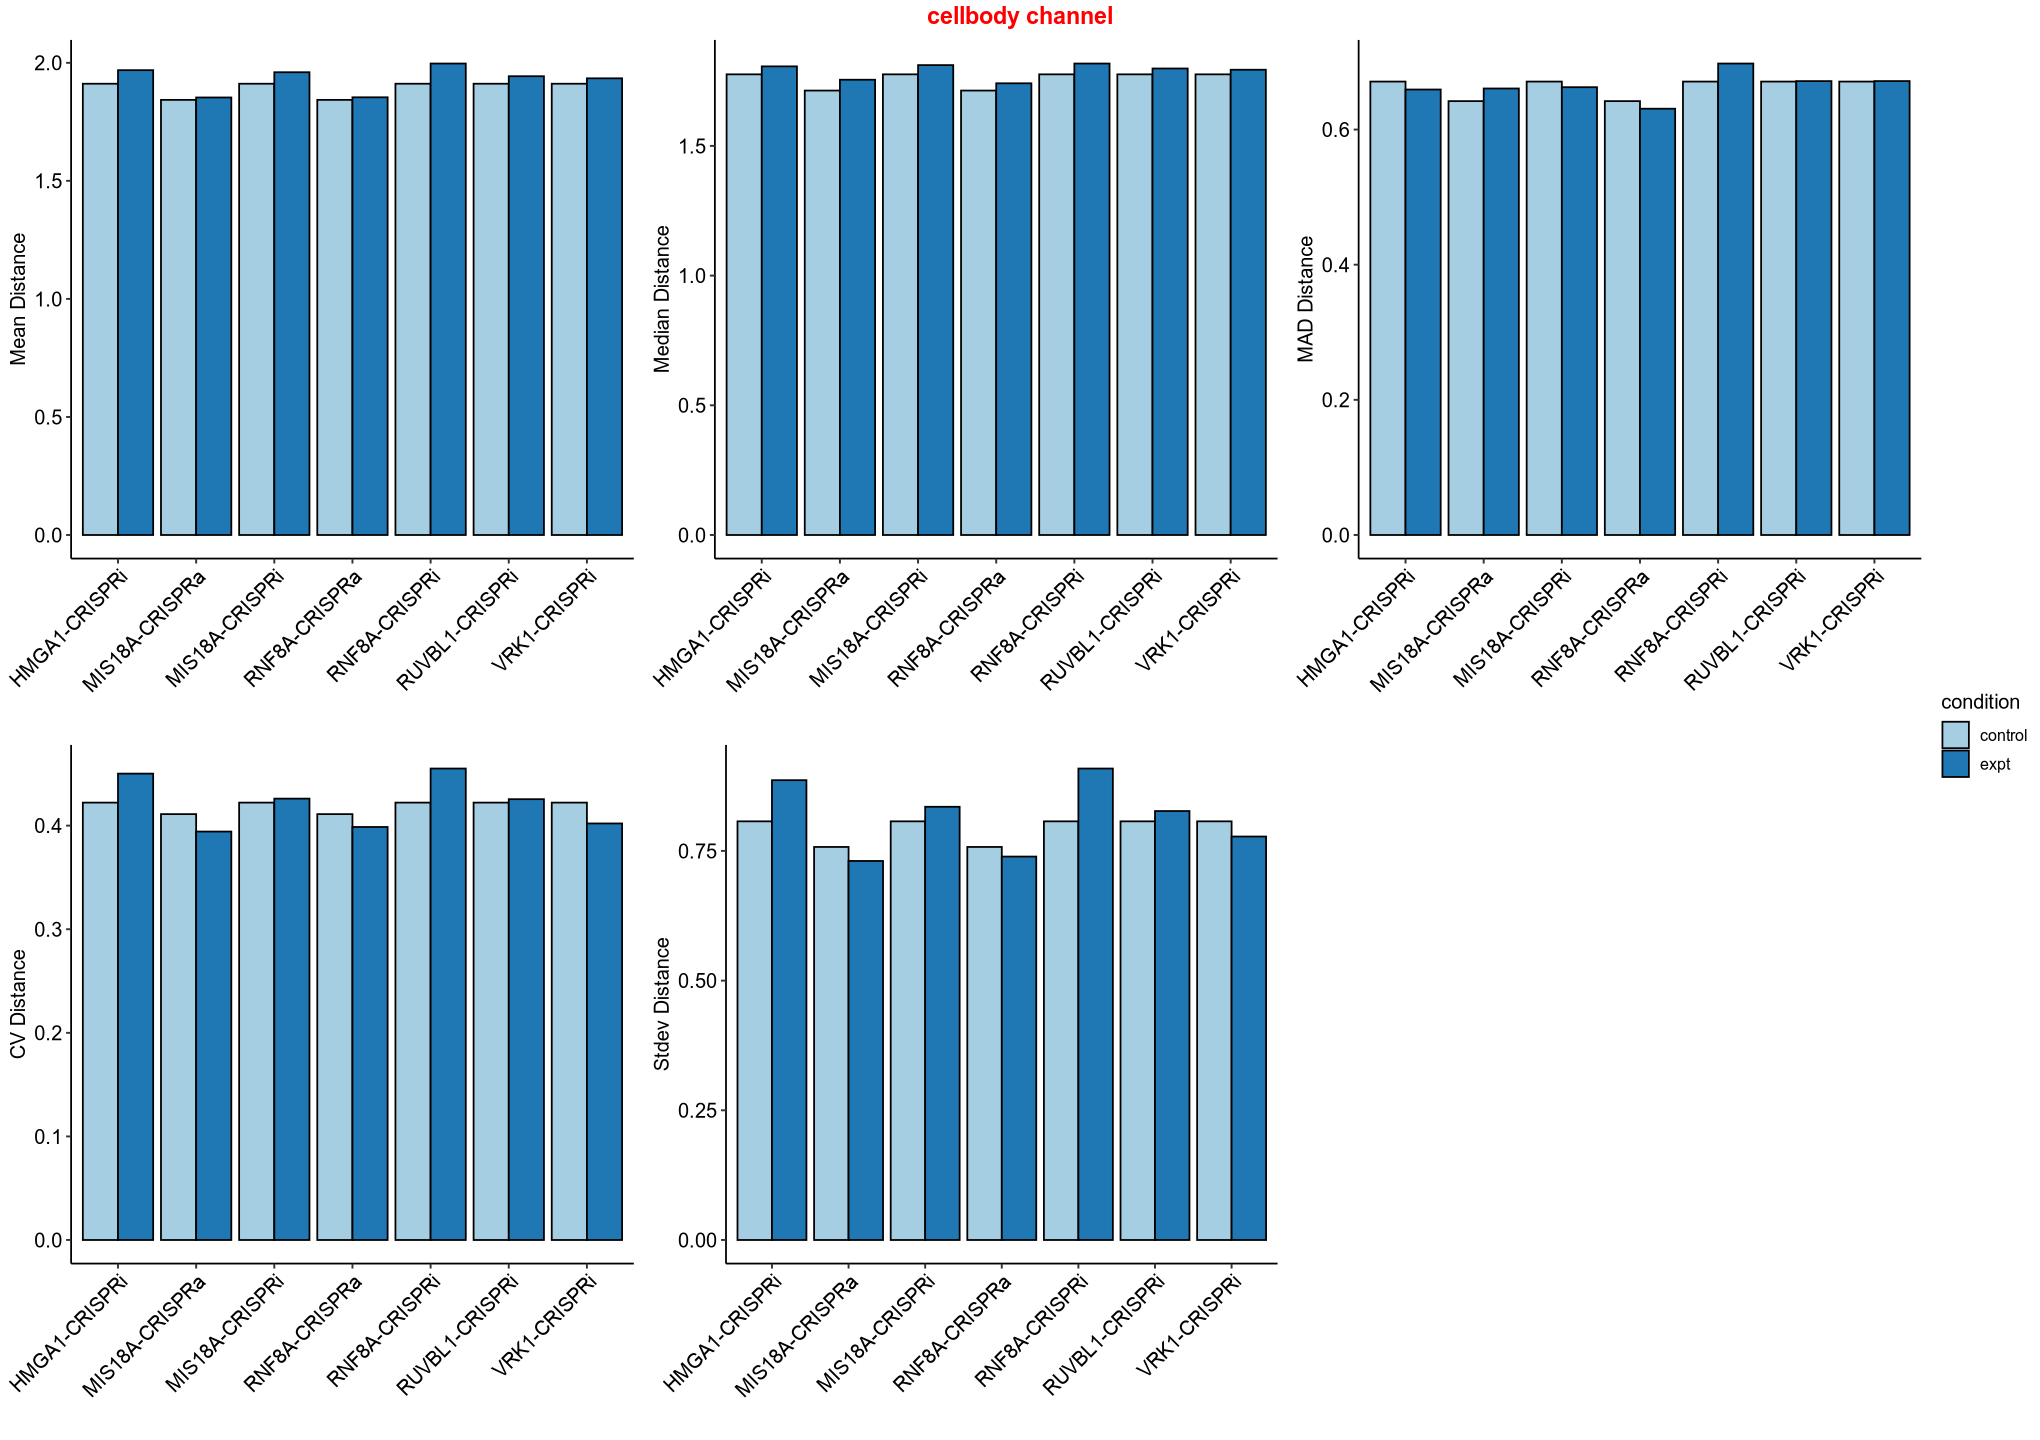

In [50]:
### PCA analysis on all features by experimental condition -- cellbody channel ###
pca1 = prcomp(primary_objects_data_PCA_cellbody, scale. = TRUE)
PCA_coordinates = pca1$x
PCA_coordinates_final = PCA_coordinates[, 1:50]

# PCA_coordinates_final -> PCA_coordinates_final_q25_q75_top2000DEGs
eigs <- pca1$sdev^2
eigen_values = eigs
explained_variance = eigs/sum(eigs)
explained_variance = explained_variance[1:50]

names = sapply(stringr::str_split(rownames(PCA_coordinates_final), '_'), '[[', 1)
PCA_coordinates_final_annoated = as.data.frame(cbind(names, PCA_coordinates_final))
list_of_PCA_coordinates_final = split(PCA_coordinates_final_annoated, f = PCA_coordinates_final_annoated$names)
list_of_PCA_coordinates_final = lapply(list_of_PCA_coordinates_final, select, -names)
list_of_PCA_coordinates_final = lapply(list_of_PCA_coordinates_final, as.matrix)
names(list_of_PCA_coordinates_final) = as.character(sapply(list_of_PCA_coordinates_final, function(x) sapply(stringr::str_split(rownames(x), '_'), '[[', 1) %>% unique()))
#list_of_PCA_coordinates_final_rownames = lapply(list_of_PCA_coordinates_final, rownames)
list_of_PCA_coordinates_final = lapply(list_of_PCA_coordinates_final, apply, 2, as.numeric)

HMGA1_CRISPRi_with_centroid = centroid_appender(list(list_of_PCA_coordinates_final[['NTCi']], list_of_PCA_coordinates_final[['HMGA1-CRISPRi']]))
MIS18A_CRISPRa_with_centroid = centroid_appender(list(list_of_PCA_coordinates_final[['NTCa']], list_of_PCA_coordinates_final[['MIS18A-CRISPRa']]))
MIS18A_CRISPRi_with_centroid = centroid_appender(list(list_of_PCA_coordinates_final[['NTCi']], list_of_PCA_coordinates_final[['MIS18A-CRISPRi']]))
RNF8A_CRISPRa_with_centroid = centroid_appender(list(list_of_PCA_coordinates_final[['NTCa']], list_of_PCA_coordinates_final[['RNF8A-CRISPRa']]))
RNF8A_CRISPRi_with_centroid = centroid_appender(list(list_of_PCA_coordinates_final[['NTCi']], list_of_PCA_coordinates_final[['RNF8A-CRISPRi']]))
RUVBL1_CRISPRi_with_centroid = centroid_appender(list(list_of_PCA_coordinates_final[['NTCi']], list_of_PCA_coordinates_final[['RUVBL1-CRISPRi']]))
VRK1_CRISPRi_with_centroid = centroid_appender(list(list_of_PCA_coordinates_final[['NTCi']], list_of_PCA_coordinates_final[['VRK1-CRISPRi']]))

list_objs = list(HMGA1_CRISPRi_with_centroid, MIS18A_CRISPRa_with_centroid, MIS18A_CRISPRi_with_centroid, RNF8A_CRISPRa_with_centroid, RNF8A_CRISPRi_with_centroid, RUVBL1_CRISPRi_with_centroid, VRK1_CRISPRi_with_centroid)
names(list_objs) = c('HMGA1-CRISPRi', 'MIS18A-CRISPRa', 'MIS18A-CRISPRi', 'RNF8A-CRISPRa', 'RNF8A-CRISPRi', 'RUVBL1-CRISPRi', 'VRK1-CRISPRi')

list_objs_distances_mean = lapply(list_objs, function(x) mean_distance_calculator(weighted_distance_calculator(x, explained_variance)))
list_objs_distances_median = lapply(list_objs, function(x) median_distance_calculator(weighted_distance_calculator(x, explained_variance)))
list_objs_distances_mad = lapply(list_objs, function(x) mad_caluclator(weighted_distance_calculator(x, explained_variance)))
list_objs_distances_cv = lapply(list_objs, function(x) cv_calculator(weighted_distance_calculator(x, explained_variance)))
list_objs_distances_stdev = lapply(list_objs, function(x) stdev_calculator(weighted_distance_calculator(x, explained_variance)))

## organizing data for plotting
metric_list = list(list_objs_distances_mean, list_objs_distances_median, list_objs_distances_mad, list_objs_distances_cv, list_objs_distances_stdev)
names(metric_list) = c('mean', 'median', 'mad', 'cv', 'stdev')
metric_list = lapply(metric_list, function(x) as.data.frame(t(as.data.frame(x))))
metric_list = lapply(metric_list, 'colnames<-', c('control', 'expt'))
metric_list = lapply(metric_list, 'rownames<-', c('HMGA1-CRISPRi', 'MIS18A-CRISPRa', 'MIS18A-CRISPRi', 'RNF8A-CRISPRa', 'RNF8A-CRISPRi', 'RUVBL1-CRISPRi', 'VRK1-CRISPRi'))
metric_list = lapply(metric_list, function(x) tibble::rownames_to_column(x, 'sample'))

metric_list = bind_rows(metric_list, .id = 'metric')
metric_df = pivot_longer(metric_list, cols = -c('sample', 'metric'), names_to = 'condition', values_to = 'value')

## plotting
mean_plot = metric_df %>% filter(metric == 'mean') %>% ggplot(aes(x = sample, y = value, fill = condition)) +
geom_bar(stat = "identity", color = "black", position=position_dodge()) +
  theme_pubr() + scale_fill_brewer(palette = "Paired") + ylab('Mean Distance') + xlab('') + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1))

median_plot = metric_df %>% filter(metric == 'median') %>% ggplot(aes(x = sample, y = value, fill = condition)) +
geom_bar(stat = "identity", color = "black", position=position_dodge()) +
  theme_pubr() + scale_fill_brewer(palette = "Paired") + ylab('Median Distance') + xlab('') + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1))

mad_plot = metric_df %>% filter(metric == 'mad') %>% ggplot(aes(x = sample, y = value, fill = condition)) +
geom_bar(stat = "identity", color = "black", position=position_dodge()) +
  theme_pubr() + scale_fill_brewer(palette = "Paired") + ylab('MAD Distance') + xlab('') + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1))

cv_plot = metric_df %>% filter(metric == 'cv') %>% ggplot(aes(x = sample, y = value, fill = condition)) +
geom_bar(stat = "identity", color = "black", position=position_dodge()) +
  theme_pubr() + scale_fill_brewer(palette = "Paired") + ylab('CV Distance') + xlab('') + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1))

stdev_plot = metric_df %>% filter(metric == 'stdev') %>% ggplot(aes(x = sample, y = value, fill = condition)) +
geom_bar(stat = "identity", color = "black", position=position_dodge()) +
  theme_pubr() + scale_fill_brewer(palette = "Paired") + ylab('Stdev Distance') + xlab('') + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1))

options(repr.plot.width = 17, repr.plot.height = 12)
plot = ggarrange(mean_plot, median_plot, mad_plot, cv_plot, stdev_plot, ncol = 3, nrow = 2, common.legend = TRUE, legend = "right")
annotate_figure(plot, top = text_grob("cellbody channel", color = "red", face = "bold", size = 14))

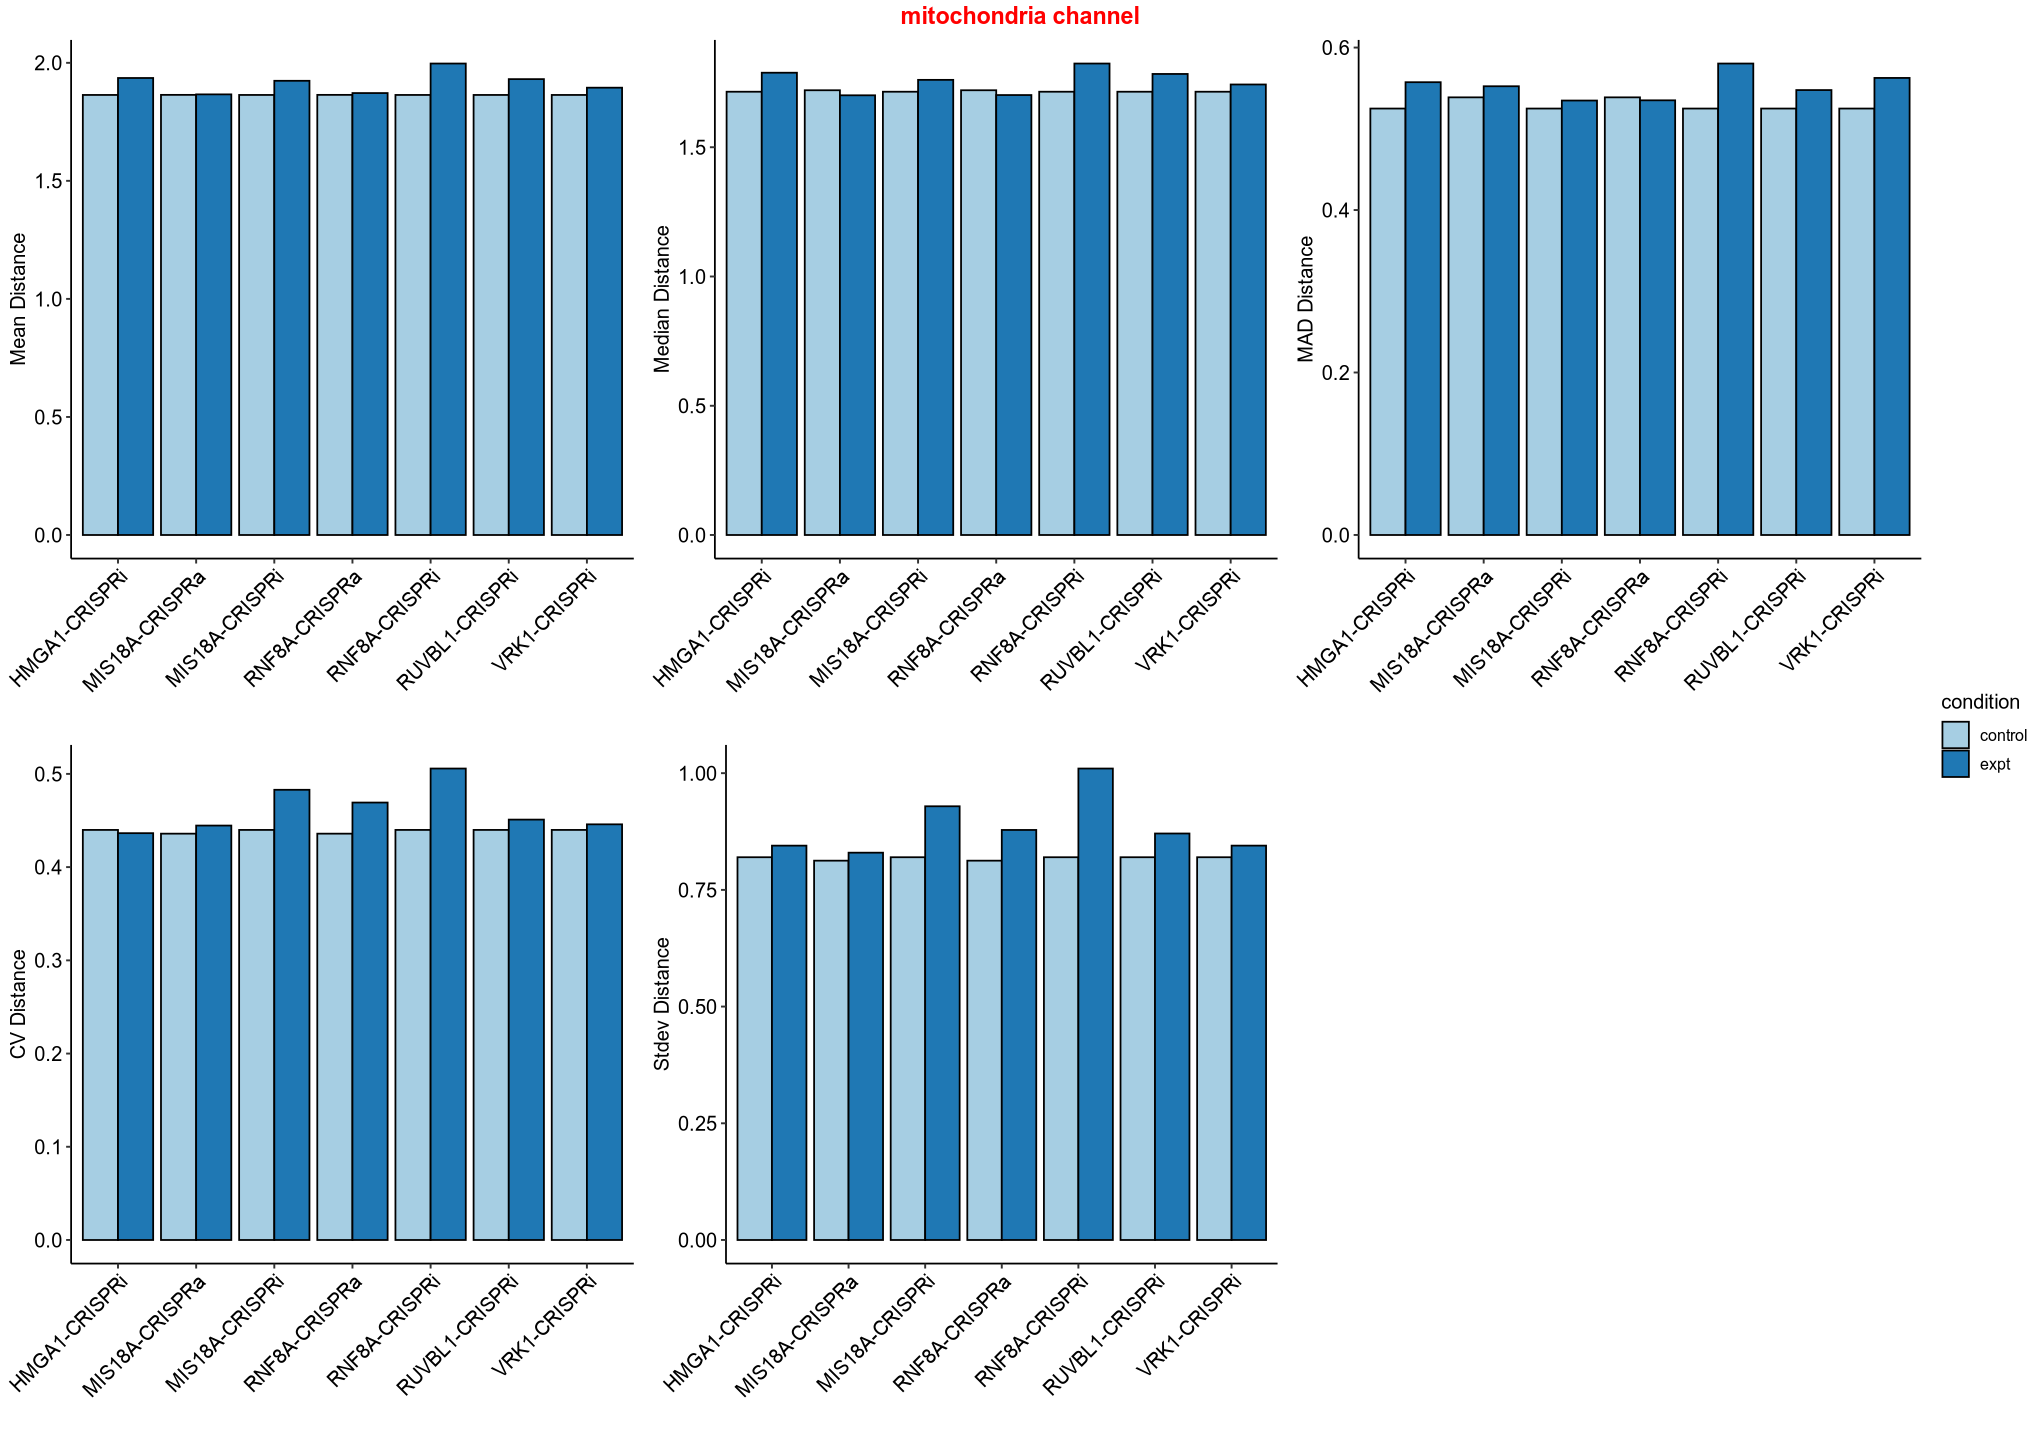

In [36]:
### PCA analysis on all features by experimental condition -- mitochondria channel ###
pca1 = prcomp(primary_objects_data_PCA_mitochondria, scale. = TRUE)
PCA_coordinates = pca1$x
PCA_coordinates_final = PCA_coordinates[, 1:50]

# PCA_coordinates_final -> PCA_coordinates_final_q25_q75_top2000DEGs
eigs <- pca1$sdev^2
eigen_values = eigs
explained_variance = eigs/sum(eigs)
explained_variance = explained_variance[1:50]

names = sapply(stringr::str_split(rownames(PCA_coordinates_final), '_'), '[[', 1)
PCA_coordinates_final_annoated = as.data.frame(cbind(names, PCA_coordinates_final))
list_of_PCA_coordinates_final = split(PCA_coordinates_final_annoated, f = PCA_coordinates_final_annoated$names)
list_of_PCA_coordinates_final = lapply(list_of_PCA_coordinates_final, select, -names)
list_of_PCA_coordinates_final = lapply(list_of_PCA_coordinates_final, as.matrix)
names(list_of_PCA_coordinates_final) = as.character(sapply(list_of_PCA_coordinates_final, function(x) sapply(stringr::str_split(rownames(x), '_'), '[[', 1) %>% unique()))
#list_of_PCA_coordinates_final_rownames = lapply(list_of_PCA_coordinates_final, rownames)
list_of_PCA_coordinates_final = lapply(list_of_PCA_coordinates_final, apply, 2, as.numeric)

HMGA1_CRISPRi_with_centroid = centroid_appender(list(list_of_PCA_coordinates_final[['NTCi']], list_of_PCA_coordinates_final[['HMGA1-CRISPRi']]))
MIS18A_CRISPRa_with_centroid = centroid_appender(list(list_of_PCA_coordinates_final[['NTCa']], list_of_PCA_coordinates_final[['MIS18A-CRISPRa']]))
MIS18A_CRISPRi_with_centroid = centroid_appender(list(list_of_PCA_coordinates_final[['NTCi']], list_of_PCA_coordinates_final[['MIS18A-CRISPRi']]))
RNF8A_CRISPRa_with_centroid = centroid_appender(list(list_of_PCA_coordinates_final[['NTCa']], list_of_PCA_coordinates_final[['RNF8A-CRISPRa']]))
RNF8A_CRISPRi_with_centroid = centroid_appender(list(list_of_PCA_coordinates_final[['NTCi']], list_of_PCA_coordinates_final[['RNF8A-CRISPRi']]))
RUVBL1_CRISPRi_with_centroid = centroid_appender(list(list_of_PCA_coordinates_final[['NTCi']], list_of_PCA_coordinates_final[['RUVBL1-CRISPRi']]))
VRK1_CRISPRi_with_centroid = centroid_appender(list(list_of_PCA_coordinates_final[['NTCi']], list_of_PCA_coordinates_final[['VRK1-CRISPRi']]))

list_objs = list(HMGA1_CRISPRi_with_centroid, MIS18A_CRISPRa_with_centroid, MIS18A_CRISPRi_with_centroid, RNF8A_CRISPRa_with_centroid, RNF8A_CRISPRi_with_centroid, RUVBL1_CRISPRi_with_centroid, VRK1_CRISPRi_with_centroid)
names(list_objs) = c('HMGA1-CRISPRi', 'MIS18A-CRISPRa', 'MIS18A-CRISPRi', 'RNF8A-CRISPRa', 'RNF8A-CRISPRi', 'RUVBL1-CRISPRi', 'VRK1-CRISPRi')

list_objs_distances_mean = lapply(list_objs, function(x) mean_distance_calculator(weighted_distance_calculator(x, explained_variance)))
list_objs_distances_median = lapply(list_objs, function(x) median_distance_calculator(weighted_distance_calculator(x, explained_variance)))
list_objs_distances_mad = lapply(list_objs, function(x) mad_caluclator(weighted_distance_calculator(x, explained_variance)))
list_objs_distances_cv = lapply(list_objs, function(x) cv_calculator(weighted_distance_calculator(x, explained_variance)))
list_objs_distances_stdev = lapply(list_objs, function(x) stdev_calculator(weighted_distance_calculator(x, explained_variance)))

## organizing data for plotting
metric_list = list(list_objs_distances_mean, list_objs_distances_median, list_objs_distances_mad, list_objs_distances_cv, list_objs_distances_stdev)
names(metric_list) = c('mean', 'median', 'mad', 'cv', 'stdev')
metric_list = lapply(metric_list, function(x) as.data.frame(t(as.data.frame(x))))
metric_list = lapply(metric_list, 'colnames<-', c('control', 'expt'))
metric_list = lapply(metric_list, 'rownames<-', c('HMGA1-CRISPRi', 'MIS18A-CRISPRa', 'MIS18A-CRISPRi', 'RNF8A-CRISPRa', 'RNF8A-CRISPRi', 'RUVBL1-CRISPRi', 'VRK1-CRISPRi'))
metric_list = lapply(metric_list, function(x) tibble::rownames_to_column(x, 'sample'))

metric_list = bind_rows(metric_list, .id = 'metric')
metric_df = pivot_longer(metric_list, cols = -c('sample', 'metric'), names_to = 'condition', values_to = 'value')

## plotting
mean_plot = metric_df %>% filter(metric == 'mean') %>% ggplot(aes(x = sample, y = value, fill = condition)) +
geom_bar(stat = "identity", color = "black", position=position_dodge()) +
  theme_pubr() + scale_fill_brewer(palette = "Paired") + ylab('Mean Distance') + xlab('') + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1))

median_plot = metric_df %>% filter(metric == 'median') %>% ggplot(aes(x = sample, y = value, fill = condition)) +
geom_bar(stat = "identity", color = "black", position=position_dodge()) +
  theme_pubr() + scale_fill_brewer(palette = "Paired") + ylab('Median Distance') + xlab('') + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1))

mad_plot = metric_df %>% filter(metric == 'mad') %>% ggplot(aes(x = sample, y = value, fill = condition)) +
geom_bar(stat = "identity", color = "black", position=position_dodge()) +
  theme_pubr() + scale_fill_brewer(palette = "Paired") + ylab('MAD Distance') + xlab('') + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1))

cv_plot = metric_df %>% filter(metric == 'cv') %>% ggplot(aes(x = sample, y = value, fill = condition)) +
geom_bar(stat = "identity", color = "black", position=position_dodge()) +
  theme_pubr() + scale_fill_brewer(palette = "Paired") + ylab('CV Distance') + xlab('') + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1))

stdev_plot = metric_df %>% filter(metric == 'stdev') %>% ggplot(aes(x = sample, y = value, fill = condition)) +
geom_bar(stat = "identity", color = "black", position=position_dodge()) +
  theme_pubr() + scale_fill_brewer(palette = "Paired") + ylab('Stdev Distance') + xlab('') + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1))

options(repr.plot.width = 17, repr.plot.height = 12)
plot = ggarrange(mean_plot, median_plot, mad_plot, cv_plot, stdev_plot, ncol = 3, nrow = 2, common.legend = TRUE, legend = "right")
annotate_figure(plot, top = text_grob("mitochondria channel", color = "red", face = "bold", size = 14))

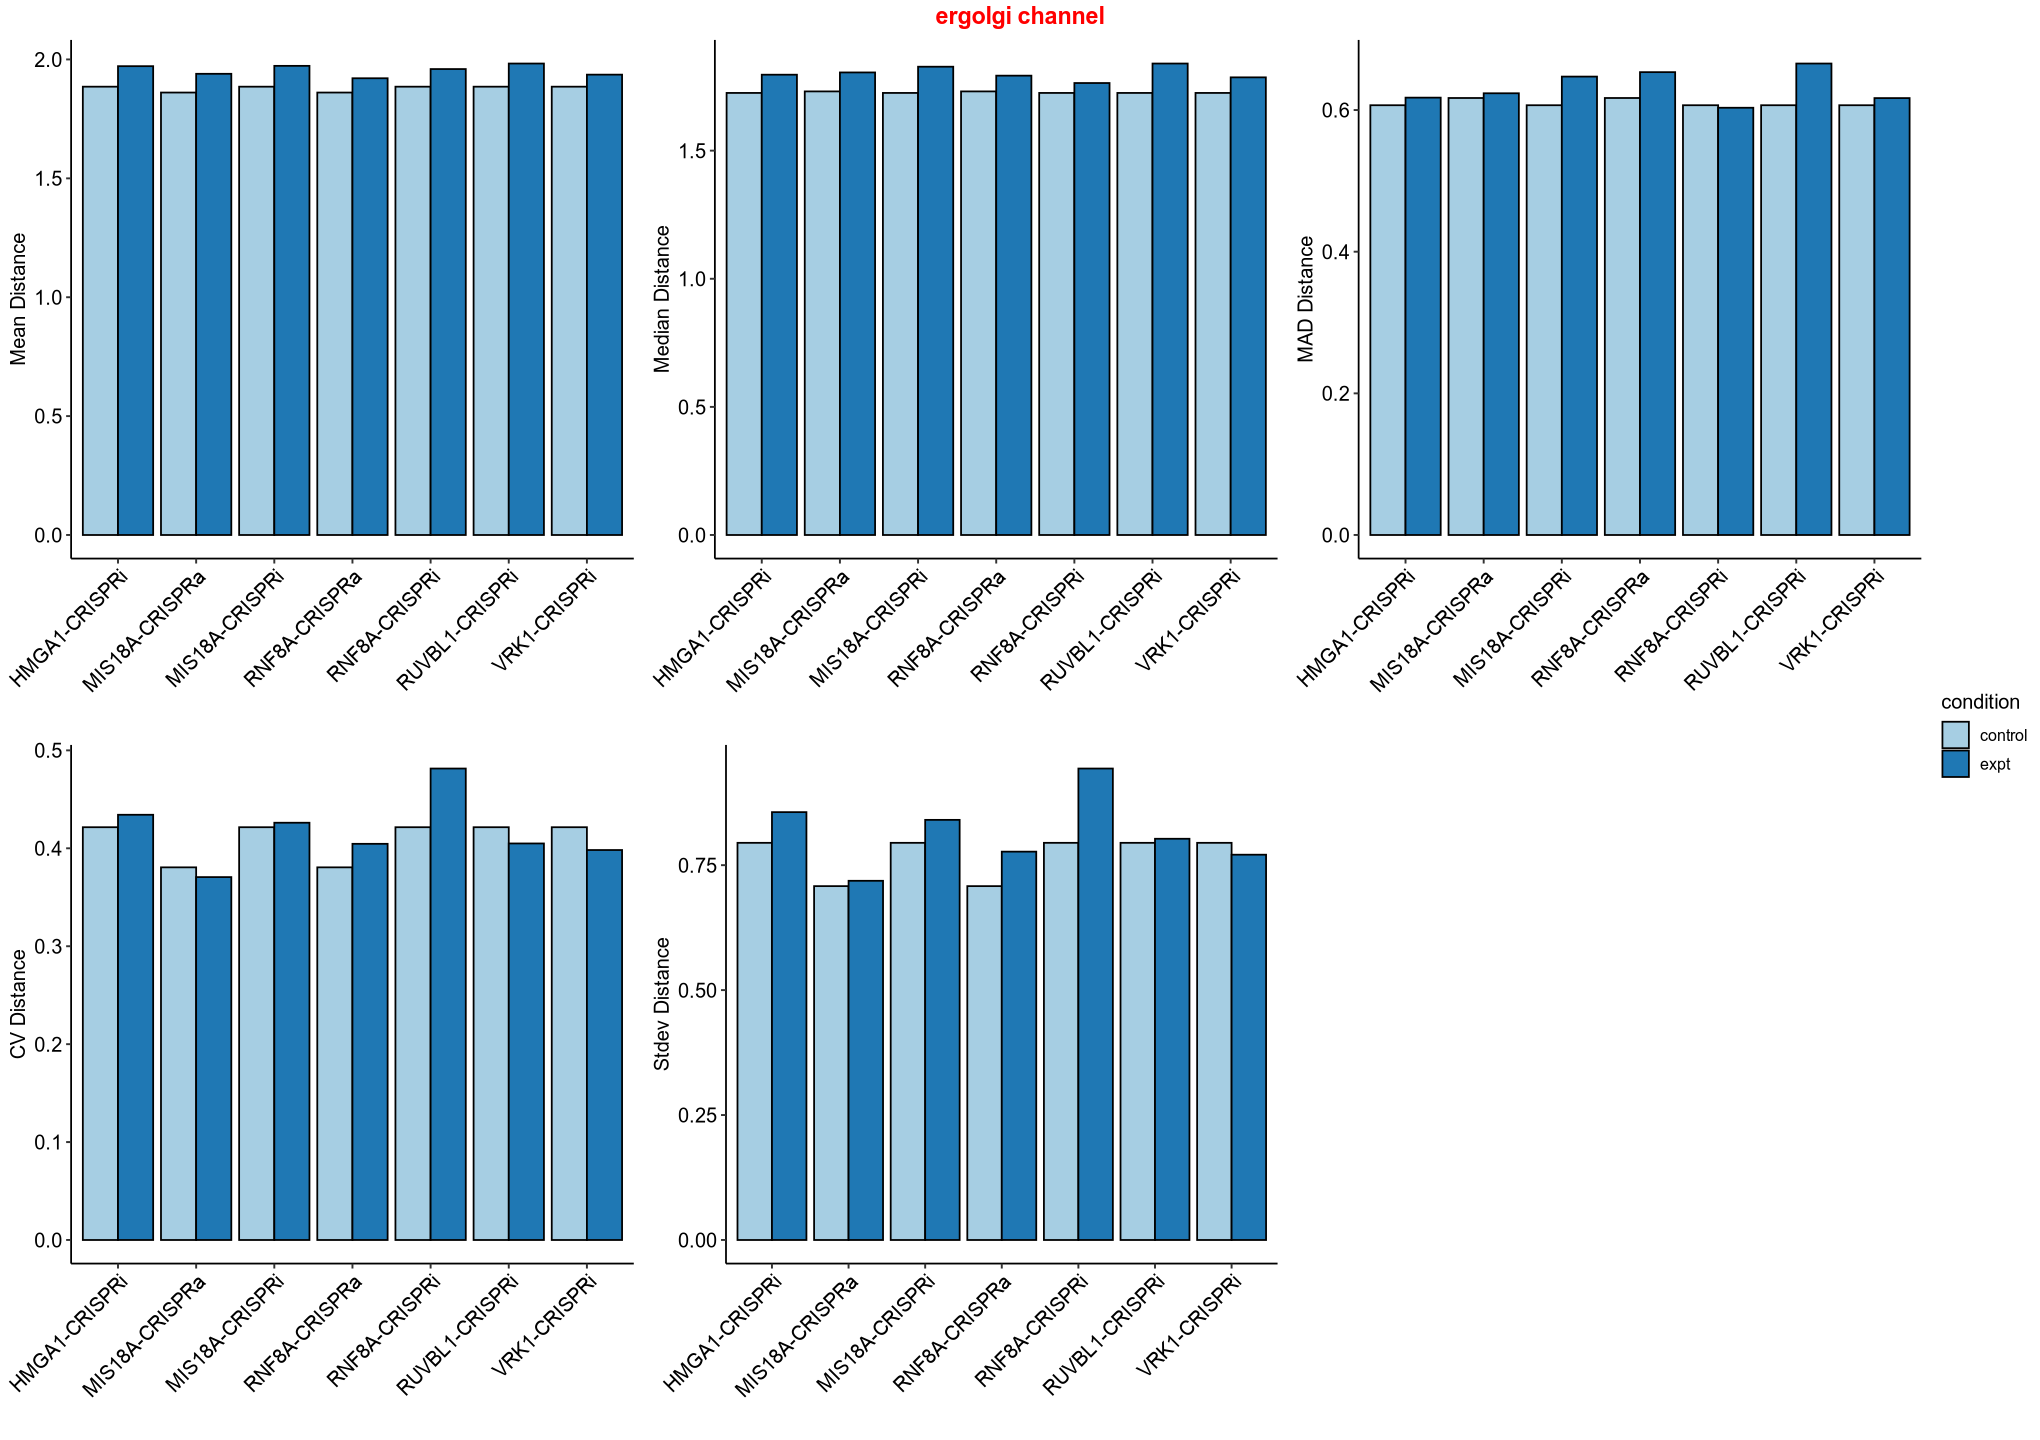

In [37]:
### PCA analysis on all features by experimental condition -- ergolgi channel ###
pca1 = prcomp(primary_objects_data_PCA_ergolgi, scale. = TRUE)
PCA_coordinates = pca1$x
PCA_coordinates_final = PCA_coordinates[, 1:50]

# PCA_coordinates_final -> PCA_coordinates_final_q25_q75_top2000DEGs
eigs <- pca1$sdev^2
eigen_values = eigs
explained_variance = eigs/sum(eigs)
explained_variance = explained_variance[1:50]

names = sapply(stringr::str_split(rownames(PCA_coordinates_final), '_'), '[[', 1)
PCA_coordinates_final_annoated = as.data.frame(cbind(names, PCA_coordinates_final))
list_of_PCA_coordinates_final = split(PCA_coordinates_final_annoated, f = PCA_coordinates_final_annoated$names)
list_of_PCA_coordinates_final = lapply(list_of_PCA_coordinates_final, select, -names)
list_of_PCA_coordinates_final = lapply(list_of_PCA_coordinates_final, as.matrix)
names(list_of_PCA_coordinates_final) = as.character(sapply(list_of_PCA_coordinates_final, function(x) sapply(stringr::str_split(rownames(x), '_'), '[[', 1) %>% unique()))
#list_of_PCA_coordinates_final_rownames = lapply(list_of_PCA_coordinates_final, rownames)
list_of_PCA_coordinates_final = lapply(list_of_PCA_coordinates_final, apply, 2, as.numeric)

HMGA1_CRISPRi_with_centroid = centroid_appender(list(list_of_PCA_coordinates_final[['NTCi']], list_of_PCA_coordinates_final[['HMGA1-CRISPRi']]))
MIS18A_CRISPRa_with_centroid = centroid_appender(list(list_of_PCA_coordinates_final[['NTCa']], list_of_PCA_coordinates_final[['MIS18A-CRISPRa']]))
MIS18A_CRISPRi_with_centroid = centroid_appender(list(list_of_PCA_coordinates_final[['NTCi']], list_of_PCA_coordinates_final[['MIS18A-CRISPRi']]))
RNF8A_CRISPRa_with_centroid = centroid_appender(list(list_of_PCA_coordinates_final[['NTCa']], list_of_PCA_coordinates_final[['RNF8A-CRISPRa']]))
RNF8A_CRISPRi_with_centroid = centroid_appender(list(list_of_PCA_coordinates_final[['NTCi']], list_of_PCA_coordinates_final[['RNF8A-CRISPRi']]))
RUVBL1_CRISPRi_with_centroid = centroid_appender(list(list_of_PCA_coordinates_final[['NTCi']], list_of_PCA_coordinates_final[['RUVBL1-CRISPRi']]))
VRK1_CRISPRi_with_centroid = centroid_appender(list(list_of_PCA_coordinates_final[['NTCi']], list_of_PCA_coordinates_final[['VRK1-CRISPRi']]))

list_objs = list(HMGA1_CRISPRi_with_centroid, MIS18A_CRISPRa_with_centroid, MIS18A_CRISPRi_with_centroid, RNF8A_CRISPRa_with_centroid, RNF8A_CRISPRi_with_centroid, RUVBL1_CRISPRi_with_centroid, VRK1_CRISPRi_with_centroid)
names(list_objs) = c('HMGA1-CRISPRi', 'MIS18A-CRISPRa', 'MIS18A-CRISPRi', 'RNF8A-CRISPRa', 'RNF8A-CRISPRi', 'RUVBL1-CRISPRi', 'VRK1-CRISPRi')

list_objs_distances_mean = lapply(list_objs, function(x) mean_distance_calculator(weighted_distance_calculator(x, explained_variance)))
list_objs_distances_median = lapply(list_objs, function(x) median_distance_calculator(weighted_distance_calculator(x, explained_variance)))
list_objs_distances_mad = lapply(list_objs, function(x) mad_caluclator(weighted_distance_calculator(x, explained_variance)))
list_objs_distances_cv = lapply(list_objs, function(x) cv_calculator(weighted_distance_calculator(x, explained_variance)))
list_objs_distances_stdev = lapply(list_objs, function(x) stdev_calculator(weighted_distance_calculator(x, explained_variance)))

## organizing data for plotting
metric_list = list(list_objs_distances_mean, list_objs_distances_median, list_objs_distances_mad, list_objs_distances_cv, list_objs_distances_stdev)
names(metric_list) = c('mean', 'median', 'mad', 'cv', 'stdev')
metric_list = lapply(metric_list, function(x) as.data.frame(t(as.data.frame(x))))
metric_list = lapply(metric_list, 'colnames<-', c('control', 'expt'))
metric_list = lapply(metric_list, 'rownames<-', c('HMGA1-CRISPRi', 'MIS18A-CRISPRa', 'MIS18A-CRISPRi', 'RNF8A-CRISPRa', 'RNF8A-CRISPRi', 'RUVBL1-CRISPRi', 'VRK1-CRISPRi'))
metric_list = lapply(metric_list, function(x) tibble::rownames_to_column(x, 'sample'))

metric_list = bind_rows(metric_list, .id = 'metric')
metric_df = pivot_longer(metric_list, cols = -c('sample', 'metric'), names_to = 'condition', values_to = 'value')

## plotting
mean_plot = metric_df %>% filter(metric == 'mean') %>% ggplot(aes(x = sample, y = value, fill = condition)) +
geom_bar(stat = "identity", color = "black", position=position_dodge()) +
  theme_pubr() + scale_fill_brewer(palette = "Paired") + ylab('Mean Distance') + xlab('') + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1))

median_plot = metric_df %>% filter(metric == 'median') %>% ggplot(aes(x = sample, y = value, fill = condition)) +
geom_bar(stat = "identity", color = "black", position=position_dodge()) +
  theme_pubr() + scale_fill_brewer(palette = "Paired") + ylab('Median Distance') + xlab('') + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1))

mad_plot = metric_df %>% filter(metric == 'mad') %>% ggplot(aes(x = sample, y = value, fill = condition)) +
geom_bar(stat = "identity", color = "black", position=position_dodge()) +
  theme_pubr() + scale_fill_brewer(palette = "Paired") + ylab('MAD Distance') + xlab('') + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1))

cv_plot = metric_df %>% filter(metric == 'cv') %>% ggplot(aes(x = sample, y = value, fill = condition)) +
geom_bar(stat = "identity", color = "black", position=position_dodge()) +
  theme_pubr() + scale_fill_brewer(palette = "Paired") + ylab('CV Distance') + xlab('') + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1))

stdev_plot = metric_df %>% filter(metric == 'stdev') %>% ggplot(aes(x = sample, y = value, fill = condition)) +
geom_bar(stat = "identity", color = "black", position=position_dodge()) +
  theme_pubr() + scale_fill_brewer(palette = "Paired") + ylab('Stdev Distance') + xlab('') + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1))

options(repr.plot.width = 17, repr.plot.height = 12)
plot = ggarrange(mean_plot, median_plot, mad_plot, cv_plot, stdev_plot, ncol = 3, nrow = 2, common.legend = TRUE, legend = "right")
annotate_figure(plot, top = text_grob("ergolgi channel", color = "red", face = "bold", size = 14))

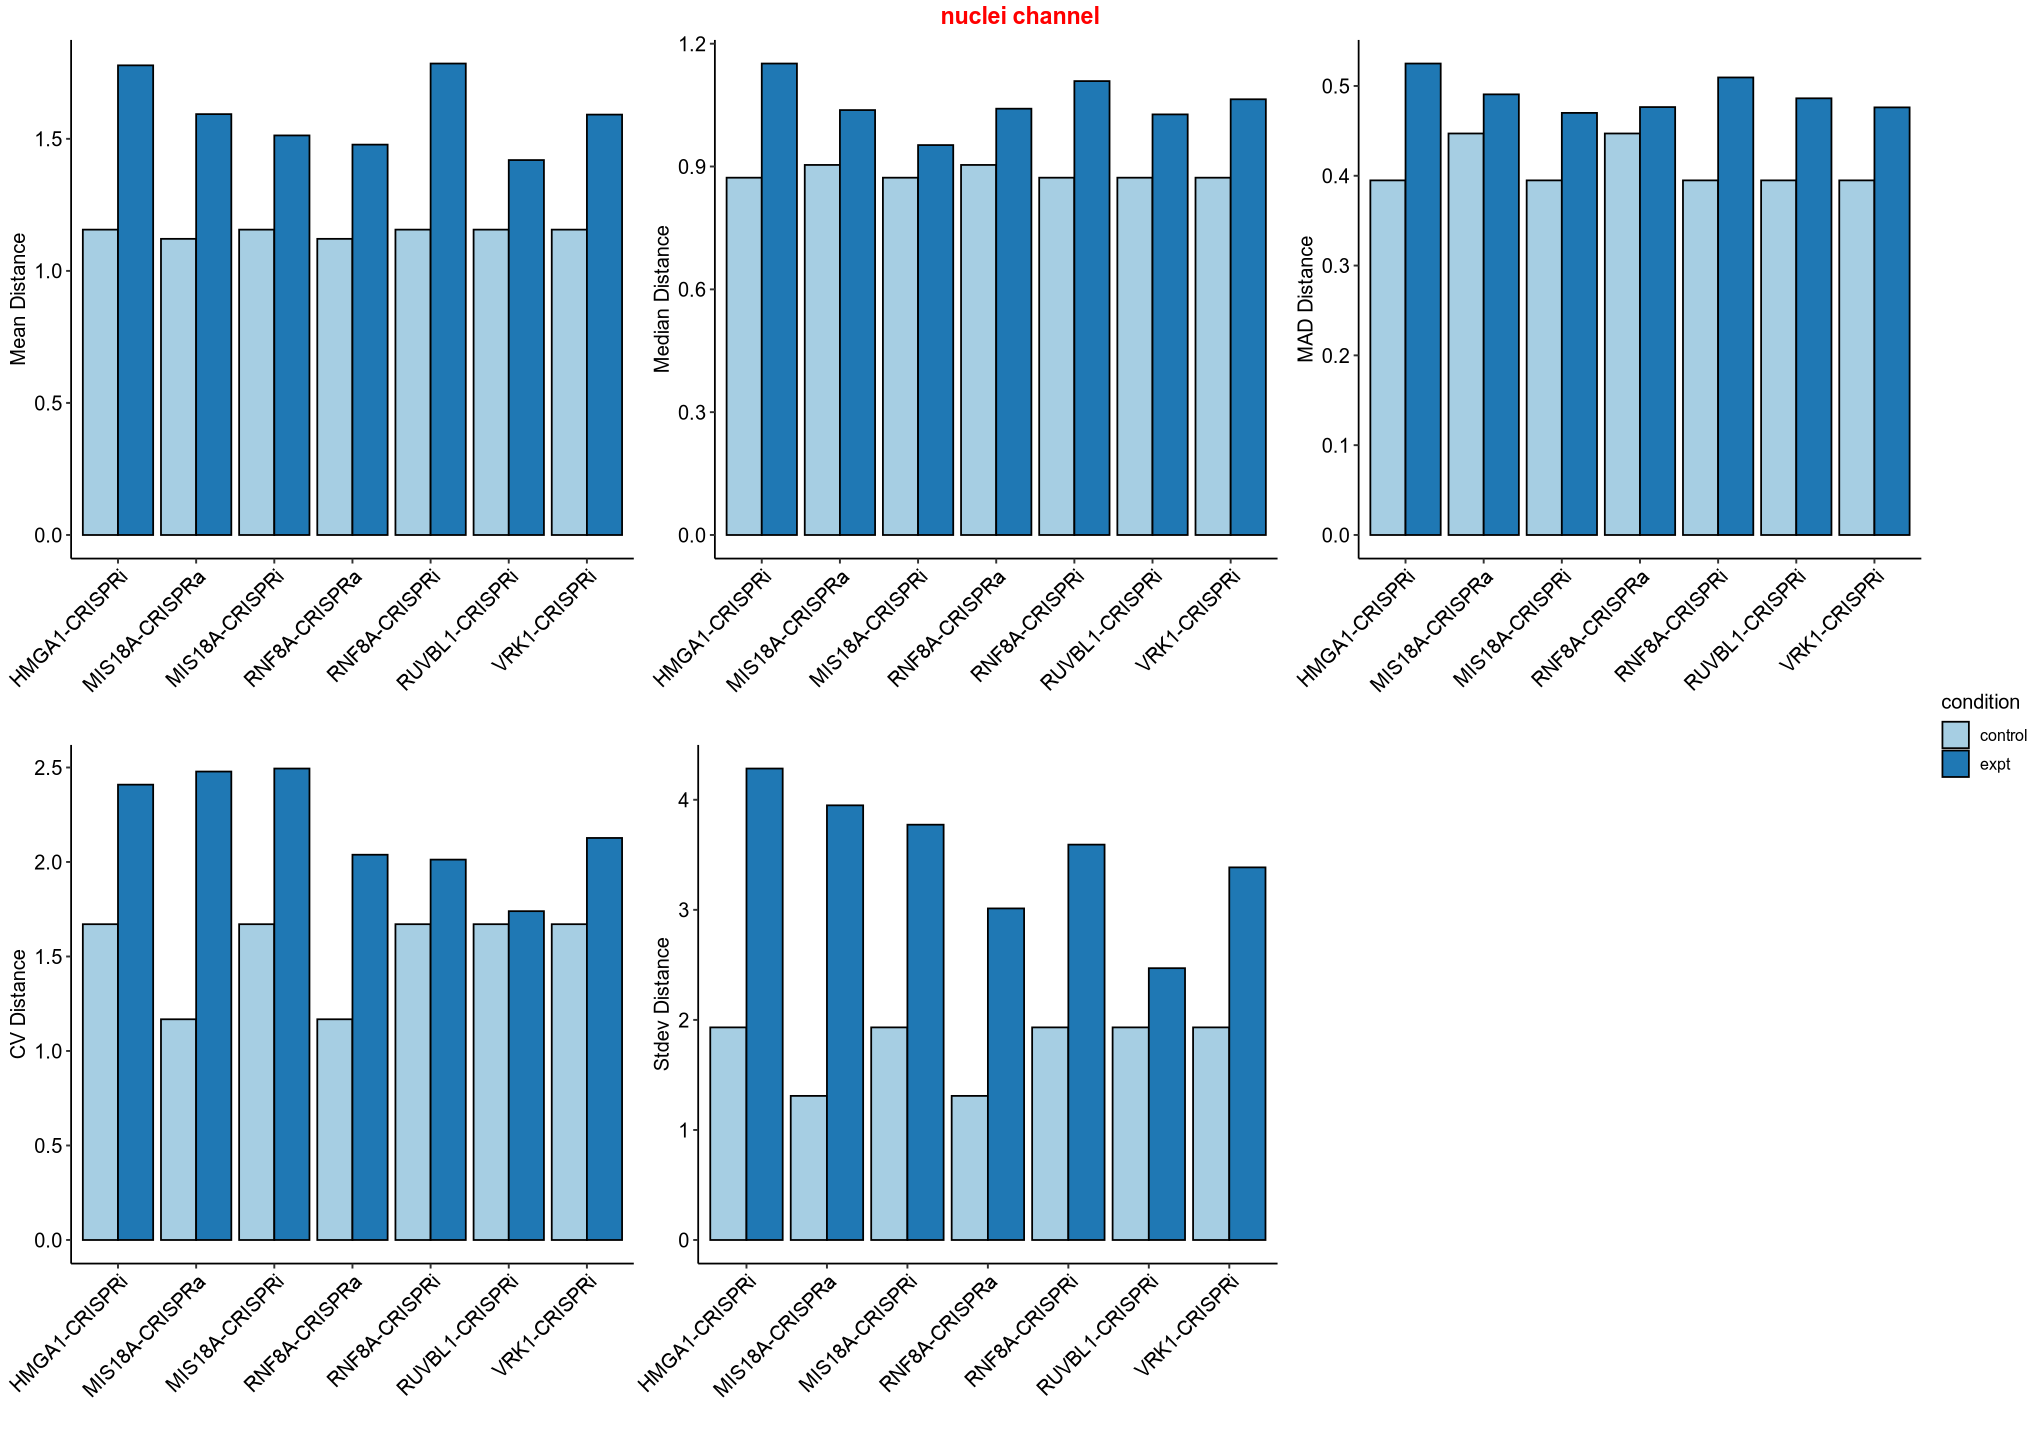

In [38]:
### PCA analysis on all features by experimental condition -- nuclei channel ###
pca1 = prcomp(primary_objects_data_PCA_nuclei[,-10], scale. = TRUE)  ## remove AreaShape_EulerNumber as it is constant
PCA_coordinates = pca1$x
PCA_coordinates_final = PCA_coordinates[, 1:50]

# PCA_coordinates_final -> PCA_coordinates_final_q25_q75_top2000DEGs
eigs <- pca1$sdev^2
eigen_values = eigs
explained_variance = eigs/sum(eigs)
explained_variance = explained_variance[1:50]

names = sapply(stringr::str_split(rownames(PCA_coordinates_final), '_'), '[[', 1)
PCA_coordinates_final_annoated = as.data.frame(cbind(names, PCA_coordinates_final))
list_of_PCA_coordinates_final = split(PCA_coordinates_final_annoated, f = PCA_coordinates_final_annoated$names)
list_of_PCA_coordinates_final = lapply(list_of_PCA_coordinates_final, select, -names)
list_of_PCA_coordinates_final = lapply(list_of_PCA_coordinates_final, as.matrix)
names(list_of_PCA_coordinates_final) = as.character(sapply(list_of_PCA_coordinates_final, function(x) sapply(stringr::str_split(rownames(x), '_'), '[[', 1) %>% unique()))
#list_of_PCA_coordinates_final_rownames = lapply(list_of_PCA_coordinates_final, rownames)
list_of_PCA_coordinates_final = lapply(list_of_PCA_coordinates_final, apply, 2, as.numeric)

HMGA1_CRISPRi_with_centroid = centroid_appender(list(list_of_PCA_coordinates_final[['NTCi']], list_of_PCA_coordinates_final[['HMGA1-CRISPRi']]))
MIS18A_CRISPRa_with_centroid = centroid_appender(list(list_of_PCA_coordinates_final[['NTCa']], list_of_PCA_coordinates_final[['MIS18A-CRISPRa']]))
MIS18A_CRISPRi_with_centroid = centroid_appender(list(list_of_PCA_coordinates_final[['NTCi']], list_of_PCA_coordinates_final[['MIS18A-CRISPRi']]))
RNF8A_CRISPRa_with_centroid = centroid_appender(list(list_of_PCA_coordinates_final[['NTCa']], list_of_PCA_coordinates_final[['RNF8A-CRISPRa']]))
RNF8A_CRISPRi_with_centroid = centroid_appender(list(list_of_PCA_coordinates_final[['NTCi']], list_of_PCA_coordinates_final[['RNF8A-CRISPRi']]))
RUVBL1_CRISPRi_with_centroid = centroid_appender(list(list_of_PCA_coordinates_final[['NTCi']], list_of_PCA_coordinates_final[['RUVBL1-CRISPRi']]))
VRK1_CRISPRi_with_centroid = centroid_appender(list(list_of_PCA_coordinates_final[['NTCi']], list_of_PCA_coordinates_final[['VRK1-CRISPRi']]))

list_objs = list(HMGA1_CRISPRi_with_centroid, MIS18A_CRISPRa_with_centroid, MIS18A_CRISPRi_with_centroid, RNF8A_CRISPRa_with_centroid, RNF8A_CRISPRi_with_centroid, RUVBL1_CRISPRi_with_centroid, VRK1_CRISPRi_with_centroid)
names(list_objs) = c('HMGA1-CRISPRi', 'MIS18A-CRISPRa', 'MIS18A-CRISPRi', 'RNF8A-CRISPRa', 'RNF8A-CRISPRi', 'RUVBL1-CRISPRi', 'VRK1-CRISPRi')

list_objs_distances_mean = lapply(list_objs, function(x) mean_distance_calculator(weighted_distance_calculator(x, explained_variance)))
list_objs_distances_median = lapply(list_objs, function(x) median_distance_calculator(weighted_distance_calculator(x, explained_variance)))
list_objs_distances_mad = lapply(list_objs, function(x) mad_caluclator(weighted_distance_calculator(x, explained_variance)))
list_objs_distances_cv = lapply(list_objs, function(x) cv_calculator(weighted_distance_calculator(x, explained_variance)))
list_objs_distances_stdev = lapply(list_objs, function(x) stdev_calculator(weighted_distance_calculator(x, explained_variance)))

## organizing data for plotting
metric_list = list(list_objs_distances_mean, list_objs_distances_median, list_objs_distances_mad, list_objs_distances_cv, list_objs_distances_stdev)
names(metric_list) = c('mean', 'median', 'mad', 'cv', 'stdev')
metric_list = lapply(metric_list, function(x) as.data.frame(t(as.data.frame(x))))
metric_list = lapply(metric_list, 'colnames<-', c('control', 'expt'))
metric_list = lapply(metric_list, 'rownames<-', c('HMGA1-CRISPRi', 'MIS18A-CRISPRa', 'MIS18A-CRISPRi', 'RNF8A-CRISPRa', 'RNF8A-CRISPRi', 'RUVBL1-CRISPRi', 'VRK1-CRISPRi'))
metric_list = lapply(metric_list, function(x) tibble::rownames_to_column(x, 'sample'))

metric_list = bind_rows(metric_list, .id = 'metric')
metric_df = pivot_longer(metric_list, cols = -c('sample', 'metric'), names_to = 'condition', values_to = 'value')

## plotting
mean_plot = metric_df %>% filter(metric == 'mean') %>% ggplot(aes(x = sample, y = value, fill = condition)) +
geom_bar(stat = "identity", color = "black", position=position_dodge()) +
  theme_pubr() + scale_fill_brewer(palette = "Paired") + ylab('Mean Distance') + xlab('') + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1))

median_plot = metric_df %>% filter(metric == 'median') %>% ggplot(aes(x = sample, y = value, fill = condition)) +
geom_bar(stat = "identity", color = "black", position=position_dodge()) +
  theme_pubr() + scale_fill_brewer(palette = "Paired") + ylab('Median Distance') + xlab('') + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1))

mad_plot = metric_df %>% filter(metric == 'mad') %>% ggplot(aes(x = sample, y = value, fill = condition)) +
geom_bar(stat = "identity", color = "black", position=position_dodge()) +
  theme_pubr() + scale_fill_brewer(palette = "Paired") + ylab('MAD Distance') + xlab('') + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1))

cv_plot = metric_df %>% filter(metric == 'cv') %>% ggplot(aes(x = sample, y = value, fill = condition)) +
geom_bar(stat = "identity", color = "black", position=position_dodge()) +
  theme_pubr() + scale_fill_brewer(palette = "Paired") + ylab('CV Distance') + xlab('') + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1))

stdev_plot = metric_df %>% filter(metric == 'stdev') %>% ggplot(aes(x = sample, y = value, fill = condition)) +
geom_bar(stat = "identity", color = "black", position=position_dodge()) +
  theme_pubr() + scale_fill_brewer(palette = "Paired") + ylab('Stdev Distance') + xlab('') + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1))

options(repr.plot.width = 17, repr.plot.height = 12)
plot = ggarrange(mean_plot, median_plot, mad_plot, cv_plot, stdev_plot, ncol = 3, nrow = 2, common.legend = TRUE, legend = "right")
annotate_figure(plot, top = text_grob("nuclei channel", color = "red", face = "bold", size = 14))


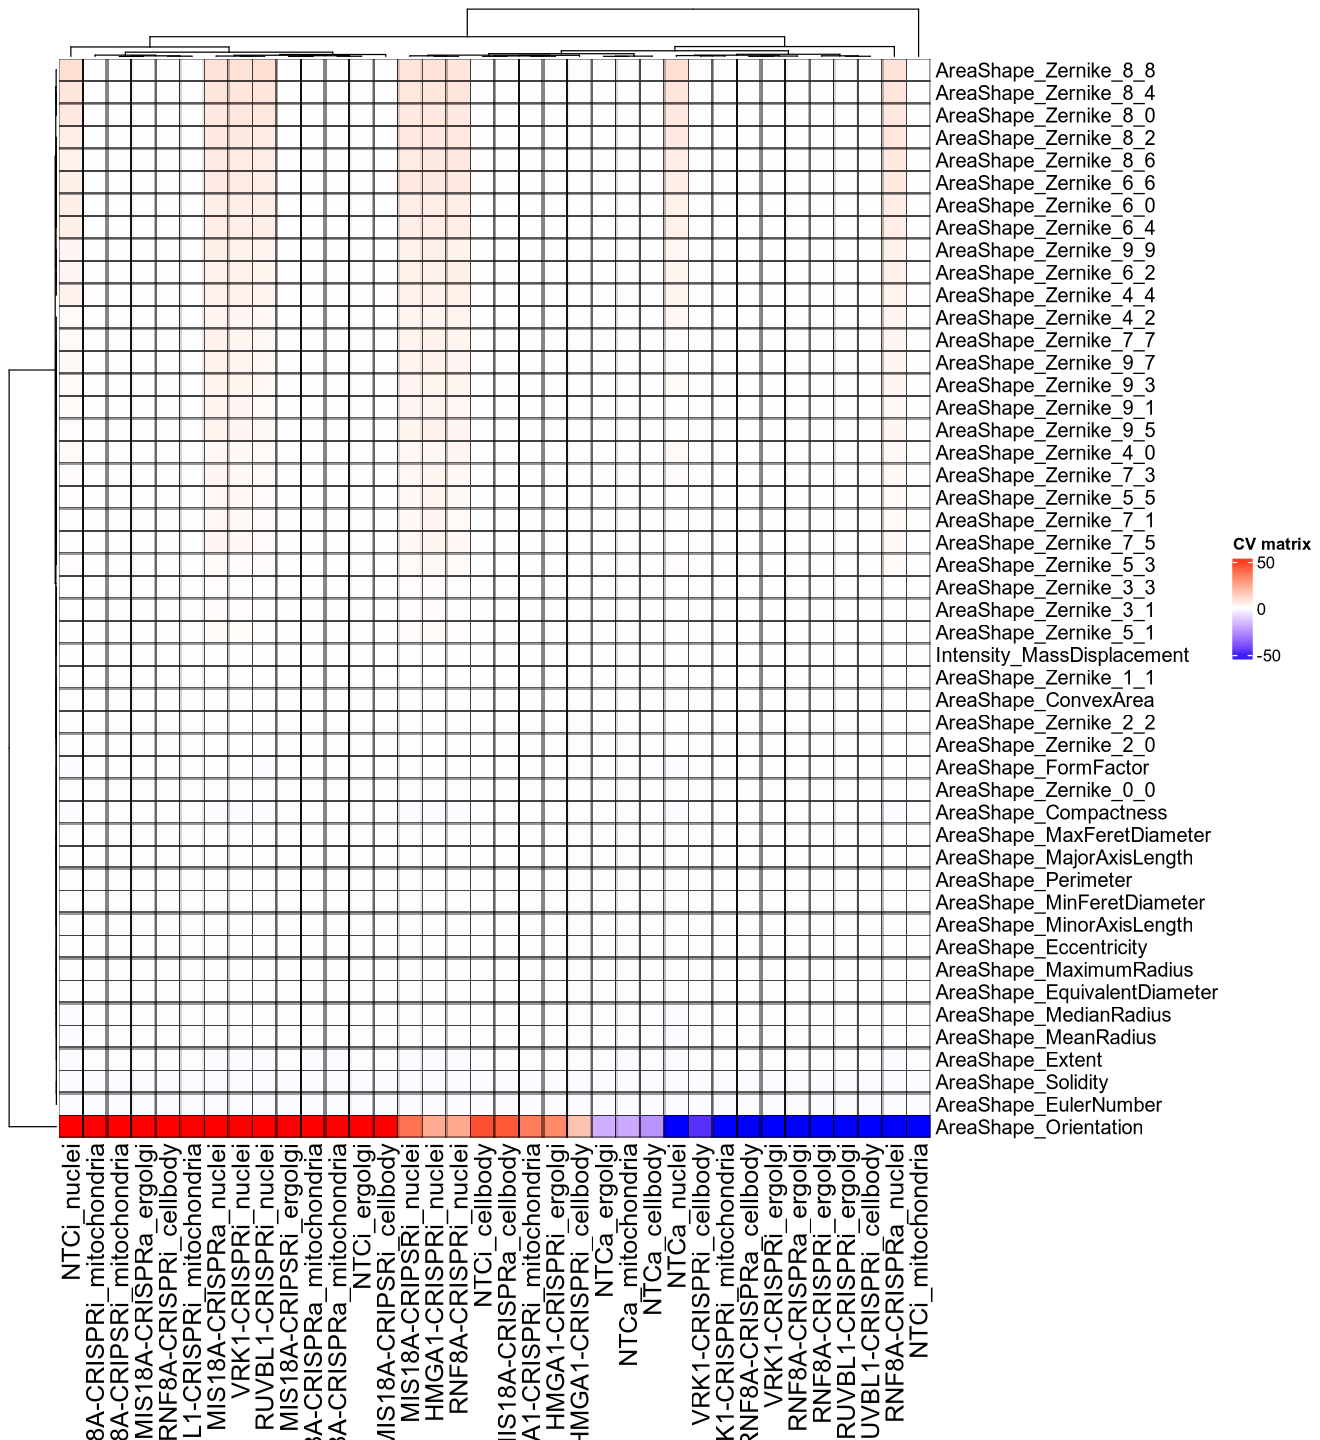

In [9]:
options(repr.plot.width=11, repr.plot.height=12)
suppressMessages(suppressWarnings(library(ComplexHeatmap)))
suppressMessages(suppressWarnings(library(gridExtra)))

avg = mean(shape_features_primary_objects_data_CV_mtx)
lower_bound = mean(shape_features_primary_objects_data_CV_mtx) - 2*sd(shape_features_primary_objects_data_CV_mtx)
upper_bound = mean(shape_features_primary_objects_data_CV_mtx) + 2*sd(shape_features_primary_objects_data_CV_mtx)
coloring_map <- circlize::colorRamp2(c(lower_bound, avg, upper_bound), c("blue", "white", "red"))

htmp <- function(matrix, title) {
  Heatmap(matrix, name = title, show_column_names = TRUE, show_row_names = TRUE, show_column_dend = TRUE,
               col = coloring_map, show_row_dend = TRUE, use_raster = TRUE, row_title = NULL, 
               column_title = NULL, row_title_side = 'left', column_title_side = 'top', 
               column_names_gp = gpar(fontsize = 15), row_names_gp = gpar(fontsize = 12), rect_gp = gpar(col = "black", lwd = 1))
}

ht1 = shape_features_primary_objects_data_CV_mtx %>% t() %>% as.data.frame() %>% select(contains('cellbody')) %>% as.matrix() %>% htmp('CV matrix')
ht2 = shape_features_primary_objects_data_CV_mtx %>% t() %>% as.data.frame() %>% select(contains('mitochondria')) %>% as.matrix() %>% htmp('CV matrix')
ht3 = shape_features_primary_objects_data_CV_mtx %>% t() %>% as.data.frame() %>% select(contains('ergolgi')) %>% as.matrix() %>% htmp('CV matrix')
ht4 = shape_features_primary_objects_data_CV_mtx %>% t() %>% as.data.frame() %>% select(contains('nuclei')) %>% as.matrix() %>% htmp('CV matrix')

ht = shape_features_primary_objects_data_CV_mtx %>% t() %>% htmp('CV matrix')
ht


In [ ]:
## complex shape features

## per object metrics
# 'AreaShape_Compactness', 'AreaShape_ConvexArea', 'AreaShape_Eccentricity', 'AreaShape_EquivalentDiameter', 'AreaShape_EulerNumber', 'AreaShape_Extent', AreaShape_FormFactor', 'AreaShape_MajorAxisLength', 'AreaShape_MinorAxisLength',
# 'AreaShape_MaxFeretDiameter', 'AreaShape_MaximumRadius', 'AreaShape_MeanRadius', 'AreaShape_MedianRadius', 'AreaShape_MinFeretDiameter', 'AreaShape_Orientation', 
# 'AreaShape_Perimeter', 'AreaShape_Solidity', 
# 'AreaShape_Zernike_0_0', 'AreaShape_Zernike_1_1', 'AreaShape_Zernike_2_0', 'AreaShape_Zernike_2_2', 'AreaShape_Zernike_3_1', 'AreaShape_Zernike_3_3', 'AreaShape_Zernike_4_0', 'AreaShape_Zernike_4_2', 'AreaShape_Zernike_4_4', 'AreaShape_Zernike_5_1', 'AreaShape_Zernike_5_3', 'AreaShape_Zernike_5_5', 'AreaShape_Zernike_6_0', 'AreaShape_Zernike_6_2', 'AreaShape_Zernike_6_4', 'AreaShape_Zernike_6_6', 'AreaShape_Zernike_7_1', 'AreaShape_Zernike_7_3', 'AreaShape_Zernike_7_5', 'AreaShape_Zernike_7_7', 'AreaShape_Zernike_8_0', 'AreaShape_Zernike_8_2', 'AreaShape_Zernike_8_4', 'AreaShape_Zernike_8_6', 'AreaShape_Zernike_8_8', 'AreaShape_Zernike_9_1', 'AreaShape_Zernike_9_3', 'AreaShape_Zernike_9_5', 'AreaShape_Zernike_9_7', 'AreaShape_Zernike_9_9'
# 'Intensity_MassDisplacement_...' 


## make heatmap of CV values of these features across conditions
## run PCA on CV values of these features and show PC1 vs PC2 plot
## run PCA on Zernike features (mean) alone to show they are distinct across conditions (ie shape is distinct across conditions)



In [ ]:
## mix all three shape, intensity, and complex shape features and run PCA on their CV values across conditions
## mix all three shape, intensity, and complex shape features and run heatmap of CV values across conditions

In [ ]:
## correlation heatmaps between features

In [4]:
nuclei %>% select(contains('Zernike')) %>% head()

,AreaShape_Zernike_0_0,AreaShape_Zernike_1_1,AreaShape_Zernike_2_0,AreaShape_Zernike_2_2,AreaShape_Zernike_3_1,AreaShape_Zernike_3_3,AreaShape_Zernike_4_0,AreaShape_Zernike_4_2,AreaShape_Zernike_4_4,AreaShape_Zernike_5_1,⋯,AreaShape_Zernike_8_0,AreaShape_Zernike_8_2,AreaShape_Zernike_8_4,AreaShape_Zernike_8_6,AreaShape_Zernike_8_8,AreaShape_Zernike_9_1,AreaShape_Zernike_9_3,AreaShape_Zernike_9_5,AreaShape_Zernike_9_7,AreaShape_Zernike_9_9
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.8820689,0.01956474,0.09145827,0.06040764,0.009708546,0.024650451,0.051571328,0.03260184,0.007493491,0.0007197546,⋯,0.0038302888,0.004788615,0.010581778,0.004532785,0.001604793,0.007880307,0.007507326,0.0078381025,0.0039237573,0.005506943
2,0.8210066,0.09516828,0.11205228,0.05294330,0.028322288,0.016114155,0.034681858,0.01107602,0.017873224,0.0180683195,⋯,0.0011502985,0.004766059,0.001453836,0.004180681,0.006533371,0.006332844,0.005749202,0.0067750748,0.0044308096,0.005378627
3,0.8331729,0.01842141,0.12336383,0.07122484,0.006572884,0.006142328,0.061381864,0.02766932,0.011928026,0.0084789565,⋯,0.0102247439,0.012966961,0.009358618,0.004475209,0.003079948,0.001193761,0.003325241,0.0002672938,0.0014687512,0.001536806
4,0.6231384,0.05358207,0.16528676,0.10622833,0.025652540,0.020572849,0.002904419,0.01825934,0.030762890,0.0136377754,⋯,0.0025092924,0.005522264,0.007791903,0.010222280,0.002842401,0.001292848,0.002933593,0.0065636983,0.0073569274,0.002600122
5,0.6913397,0.03428123,0.15208097,0.10837478,0.008099189,0.029149115,0.009487026,0.02109209,0.028076514,0.0103067013,⋯,0.0005083938,0.008659693,0.010517278,0.008787845,0.005254259,0.004468488,0.004670031,0.0043660729,0.0088118163,0.003676484
6,0.8452167,0.11035549,0.07944820,0.04905163,0.030115881,0.022672345,0.011415921,0.01288383,0.014966843,0.0102008197,⋯,0.0031749155,0.006399581,0.008898976,0.005031400,0.011353179,0.002647437,0.013866284,0.0038439256,0.0008277067,0.013024094


In [30]:
head(Image)

,Channel_DNA,Channel_ERGolgi,Channel_Mitochondria,Channel_cellbody,Count_ERGolgi,Count_Mitochondria,Count_Nuclei,Count_cell_borders_secondary_via_nuclei,Count_cellbody,Count_cytoplasm_borders_tertiary_via_nuclei_primary_cell_borders_secondary,⋯,Threshold_WeightedVariance_cellbody,URL_DNA,URL_ERGolgi,URL_Mitochondria,URL_cell_borders_secondary_via_nuclei_on_DNA_stain_image,URL_cellbody,Width_DNA,Width_ERGolgi,Width_Mitochondria,Width_cellbody
,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>
1,-1,-1,-1,-1,200,196,216,216,197,216,⋯,0.14787116,file:/home/ssobti/projects/heterogeneity_brian/data/052924_cell_painting_assay/MDATH52924/10x/MDATH52924-1/t1_A01_s1_w5_z1.tif,file:/home/ssobti/projects/heterogeneity_brian/data/052924_cell_painting_assay/MDATH52924/10x/MDATH52924-1/t1_A01_s1_w4_z1.tif,file:/home/ssobti/projects/heterogeneity_brian/data/052924_cell_painting_assay/MDATH52924/10x/MDATH52924-1/t1_A01_s1_w1_z1.tif,file:/home/ssobti/projects/heterogeneity_brian/output_data/cell_painting/10x_v1/t1_A01_s1_w5_z1_overlay.png,file:/home/ssobti/projects/heterogeneity_brian/data/052924_cell_painting_assay/MDATH52924/10x/MDATH52924-1/t1_A01_s1_w3_z1.tif,2048,2048,2048,2048
2,-1,-1,-1,-1,148,150,164,164,141,164,⋯,0.11988214,file:/home/ssobti/projects/heterogeneity_brian/data/052924_cell_painting_assay/MDATH52924/10x/MDATH52924-1/t1_A01_s2_w5_z1.tif,file:/home/ssobti/projects/heterogeneity_brian/data/052924_cell_painting_assay/MDATH52924/10x/MDATH52924-1/t1_A01_s2_w4_z1.tif,file:/home/ssobti/projects/heterogeneity_brian/data/052924_cell_painting_assay/MDATH52924/10x/MDATH52924-1/t1_A01_s2_w1_z1.tif,file:/home/ssobti/projects/heterogeneity_brian/output_data/cell_painting/10x_v1/t1_A01_s2_w5_z1_overlay.png,file:/home/ssobti/projects/heterogeneity_brian/data/052924_cell_painting_assay/MDATH52924/10x/MDATH52924-1/t1_A01_s2_w3_z1.tif,2048,2048,2048,2048
3,-1,-1,-1,-1,185,182,211,211,176,211,⋯,0.14506354,file:/home/ssobti/projects/heterogeneity_brian/data/052924_cell_painting_assay/MDATH52924/10x/MDATH52924-1/t1_A01_s3_w5_z1.tif,file:/home/ssobti/projects/heterogeneity_brian/data/052924_cell_painting_assay/MDATH52924/10x/MDATH52924-1/t1_A01_s3_w4_z1.tif,file:/home/ssobti/projects/heterogeneity_brian/data/052924_cell_painting_assay/MDATH52924/10x/MDATH52924-1/t1_A01_s3_w1_z1.tif,file:/home/ssobti/projects/heterogeneity_brian/output_data/cell_painting/10x_v1/t1_A01_s3_w5_z1_overlay.png,file:/home/ssobti/projects/heterogeneity_brian/data/052924_cell_painting_assay/MDATH52924/10x/MDATH52924-1/t1_A01_s3_w3_z1.tif,2048,2048,2048,2048
4,-1,-1,-1,-1,139,139,153,153,137,153,⋯,0.14149302,file:/home/ssobti/projects/heterogeneity_brian/data/052924_cell_painting_assay/MDATH52924/10x/MDATH52924-1/t1_A01_s4_w5_z1.tif,file:/home/ssobti/projects/heterogeneity_brian/data/052924_cell_painting_assay/MDATH52924/10x/MDATH52924-1/t1_A01_s4_w4_z1.tif,file:/home/ssobti/projects/heterogeneity_brian/data/052924_cell_painting_assay/MDATH52924/10x/MDATH52924-1/t1_A01_s4_w1_z1.tif,file:/home/ssobti/projects/heterogeneity_brian/output_data/cell_painting/10x_v1/t1_A01_s4_w5_z1_overlay.png,file:/home/ssobti/projects/heterogeneity_brian/data/052924_cell_painting_assay/MDATH52924/10x/MDATH52924-1/t1_A01_s4_w3_z1.tif,2048,2048,2048,2048
5,-1,-1,-1,-1,72,72,77,77,69,77,⋯,0.07724961,file:/home/ssobti/projects/heterogeneity_brian/data/052924_cell_painting_assay/MDATH52924/10x/MDATH52924-1/t1_A01_s5_w5_z1.tif,file:/home/ssobti/projects/heterogeneity_brian/data/052924_cell_painting_assay/MDATH52924/10x/MDATH52924-1/t1_A01_s5_w4_z1.tif,file:/home/ssobti/projects/heterogeneity_brian/data/052924_cell_painting_assay/MDATH52924/10x/MDATH52924-1/t1_A01_s5_w1_z1.tif,file:/home/ssobti/projects/heterogeneity_brian/output_data/cell_painting/10x_v1/t1_A01_s5_w5_z1_overlay.png,file:/home/ssobti/projects/heterogeneity_brian/data/052924_cell_painting_assay/MDATH52924/10x/MDATH52924-1/t1_A01_s5_w3_z1.tif,2048,2048,2048,2048
6,

In [11]:
colnames(Image)

[1] "Channel_DNA"                                                               
  [2] "Channel_ERGolgi"                                                           
  [3] "Channel_Mitochondria"                                                      
  [4] "Channel_cellbody"                                                          
  [5] "Count_ERGolgi"                                                             
  [6] "Count_Mitochondria"                                                        
  [7] "Count_Nuclei"                                                              
  [8] "Count_cell_borders_secondary_via_nuclei"                                   
  [9] "Count_cellbody"                                                            
 [10] "Count_cytoplasm_borders_tertiary_via_nuclei_primary_cell_borders_secondary"
 [11] "ExecutionTime_01Images"                                                    
 [12] "ExecutionTime_02Metadata"                                                  
 [13] "ExecutionTime_03NamesAndTypes"                                             
 [14] "ExecutionTime_04Groups"                                                    
 [15] "ExecutionTime_05IdentifyPrimaryObjects"                                    
 [16] "ExecutionTime_06IdentifyPrimaryObjects"                                    
 [17] "ExecutionTime_07IdentifyPrimaryObjects"                                    
 [18] "ExecutionTime_08IdentifyPrimaryObjects"                                    
 [19] "ExecutionTime_09IdentifySecondaryObjects"                                  
 [20] "ExecutionTime_10RelateObjects"                                             
 [21] "ExecutionTime_11IdentifyTertiaryObjects"                                   
 [22] "ExecutionTime_12MeasureObjectIntensity"                                    
 [23] "ExecutionTime_13MeasureObjectSizeShape"                                    
 [24] "ExecutionTime_14OverlayOutlines"                                           
 [25] "ExecutionTime_15SaveImages"                                                
 [26] "FileName_DNA"                                                              
 [27] "FileName_ERGolgi"                                                          
 [28] "FileName_Mitochondria"                                                     
 [29] "FileName_cell_borders_secondary_via_nuclei_on_DNA_stain_image"             
 [30] "FileName_cellbody"                                                         
 [31] "Frame_DNA"                                                                 
 [32] "Frame_ERGolgi"                                                             
 [33] "Frame_Mitochondria"                                                        
 [34] "Frame_cellbody"                                                            
 [35] "Group_Index"                                                               
 [36] "Group_Length"                                                              
 [37] "Group_Number"                                                              
 [38] "Height_DNA"                                                                
 [39] "Height_ERGolgi"                                                            
 [40] "Height_Mitochondria"                                                       
 [41] "Height_cellbody"                                                           
 [42] "ImageNumber"                                                               
 [43] "ImageSet_ImageSet"                                                         
 [44] "MD5Digest_DNA"                                                             
 [45] "MD5Digest_ERGolgi"                                                         
 [46] "MD5Digest_Mitochondria"                                                    
 [47] "MD5Digest_cellbody"                                                        
 [48] "Metadata_ChannelNumber"                                                    
 [49] "Metadata_Fi